

**Neural Machine Translation implemented using**






> **1)Vanilla RNN and**

> **2)RNN with LSTM and Attention Mechanism**





**Project Implementation Contents**
> 0.Project Description

> 1.Setup

> 2.Data Preprocessing

> 3.**machine translation model Using vanilla(Basic) RNN**

    3.1 RNN
    3.2 Encoder
         -including implementation
    3.3 Decoder
         -including implementation
    3.4 NMTRNN
         -including implementation
    3.5 Training
    3.6 Prediction

>**4.Incorporating LSTM,implemented from scratch, and Attention mechanism to our model**




    4.1 Difference Between Vanilla RNN and RNN with LSTM and Attention
    4.2 LSTM
         -including implementation from scratch
    4.3 Attention
         -scaled dot product attention
    4.4 Encoder with LSTM Incorporated
        -including implementation
    4.5 Decoder with Attention Mechanism Incorporated
        --including implementation
    4.6 Training
    4.7 Prediction

>5.Sources and ways you can experiment

##0. **Project Description**

In this project, I worked on Neural Machine Translation (NMT) and implemented** two distinct implementation**, NMT models using the Recurrent Neural Networks (RNNs) and NMT using RNNs with Long Short-Term Memory (LSTM) units and attention mechanisms.

The first part of the project is implementation using vanilla RNN. RNNs, known for their ability to capture temporal dependencies, form the core of many NMT models. It's their inherent ability to handle sequences of varying lengths that makes them highly suitable for language translation tasks. In this project, vanilla RNN  based NMT model will be the first implementation.

After this first implementation,I will move on to the next level - LSTM with attention mechanism. Although RNNs are powerful, they often encounter issues such as the vanishing gradient problem. This is where the LSTM units come into play. Designed to remember long-term dependencies, they provide a solution to these traditional issues faced by RNNs.

What sets this part of the project apart, is that **I will not just be using pre-built libraries for LSTM but rather, I will be coding LSTM from scratch**.I manually coded LSTM to obtain a deeper understanding of the inner workings of the LSTM unit and its underlying principles.

Furthermore, to enhance the translation quality of our LSTM based NMT model, I will integrate the attention mechanism into our model. Attention mechanism allows the model to focus on relevant parts of the input sequence, thereby leading to more accurate translations.

To sum it up, this project will deal about Neural Machine Translation, implementing vanilla RNN-based NMT model and a more complex LSTM-based model with attention mechanism, **all coded from scratch**. I hope you will find a lot of joy while reading it!

##1. Setup

First let's import some libraries that will be useful in our implementation.


In [ ]:
import zipfile
import matplotlib.pyplot as plt
import random
import collections
import numpy as np
import torch
import os
import torch.nn as nn
import torch.nn.functional as F

def seed(seed):
  torch.manual_seed(seed)
  np.random.seed(seed)

Make sure you are using the **GPU**. Run the code in **google colab** since it has **large dataset ** it takes too much time in CPU.It may not run in VsCode as well if you don't have GPU

In [ ]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

device = torch.device('cuda:0')

Good to go!


For the project, I will use an English-to-French dataset. As shown below, the dataset contains multiple lines each of which has an English sentence and its French translation separated by a tab. In the project, since English is translated to French, English is the source language and French is the target language. Note that each text sequence is of variable length and can be just one sentence or a paragraph of multiple sentences.

In [ ]:
def download_if_not_exist(file_name):

  if not os.path.exists(file_name):
    import urllib.request
    DATA_URL = 'https://download.pytorch.org/tutorial/data.zip'

    file_name, _ = urllib.request.urlretrieve(DATA_URL, './data.zip')

  return file_name

def read_raw(file_name):
  file_name = download_if_not_exist(file_name)

  with zipfile.ZipFile(file_name, 'r') as fzip:
    raw_text = fzip.read(file_name.split('.')[-2][1:] + '/eng-fra.txt').decode('utf-8')
  return raw_text

In [ ]:
raw_text = read_raw('./data.zip')
print(raw_text[:200])

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !
Wait!	Attends !
Wait!	Attendez !
I see.	Je comprends.


##2. Data Preprocessing

Next we'll do some preprocessing on this raw text. We need to replace special symbols (non-breaking spaces) with spaces, convert all characters to lower case, and insert a space between words and punctuation marks.

In [ ]:
def preprocess_raw(text):
  text = text.replace('\u202f', ' ').replace('\xa0', ' ')
  out = ''
  for i, char in enumerate(text.lower()):
    if char in (',', '!', '.') and i > 0 and text[i-1] != ' ':
      out += ' '
    out += char
  return out

We further split the source-target pairs into a source list and a target list. We use word-level tokenization here.

In [ ]:
def split_source_target(text, max_len):
  source, target = [], []
  for i, line in enumerate(text.split('\n')):
    if i > 5000: # we only use 5000 pairs of translation
      break
    parts = line.split('\t')
    if len(parts) == 2:
      src_tokens = parts[0].split(' ')
      tgt_tokens = parts[1].split(' ')
      if (len(src_tokens) <= max_len) and (len(tgt_tokens) <= max_len):
        source.append(src_tokens)
        target.append(tgt_tokens)
  return source, target

In [ ]:
def prepare_data(raw_text, max_len=10000):
  text = preprocess_raw(raw_text)
  source, target = split_source_target(text, max_len)
  return source, target

source, target = prepare_data(raw_text)

Using the whole dataset takes too much memory, and it is hard to train with a large vocabulary. Thus, we will filter out some words by looking at the statistical properties of the dataset.

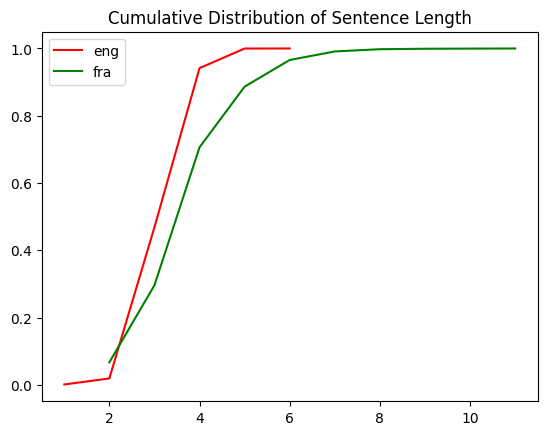

In [ ]:
def len_dis(text):
  lens = [len(line) for line in text]
  len_counter = collections.Counter(lens)

  lens = np.array(list(len_counter.keys()))
  sort_idx = np.argsort(lens)
  lens_sort = lens[sort_idx]
  len_counts = np.array(list(len_counter.values()))
  len_counts_sort = len_counts[sort_idx]
  p = np.cumsum(len_counts_sort) / len_counts_sort.sum()
  return p, lens_sort

src_p, src_lens_sort = len_dis(source)
tgt_p, tgt_lens_sort = len_dis(target)
plt.plot(src_lens_sort, src_p, 'r-', label='eng')
plt.plot(tgt_lens_sort, tgt_p, 'g-', label='fra')
plt.title('Cumulative Distribution of Sentence Length')
plt.legend()
plt.show()

From the above plots, we can see that more than 90% of the sentences have a length of less than 8. Thus, we can filter out sentences of length greater than 8. We also filter out words that occur less than 5 times in the corpus.

In [ ]:
# hyper-param
MAX_LEN = 8
MIN_FREQ = 5

### Build Vocabulary

Each word needs a unique index, and the words that have been filtered out need a special token to represent them. The following class Vocab is used to build the vocabulary. Some basic helper functions or dictionaries are also provided:
- Dictionary word2index: Convert word string into index:
- Dictionary index2word: Convert index into word string
- helper function _build_vocab(): Build dictionaries for converting from words to indices and vice versa
- Word Counter, num_word: Record the total number of unique tokens in the vocabulary

There are 4 special tokens added in the vocabulary:
- 'pad': padding token. Sentences shorter than MAX_LEN is padded by this symbol to make the length to MAX_LEN
- 'bos': beginning of sentence. This indicates the beginning of a sentence
- 'eos': end of sentence. This indicates the end of a sentence
- 'unk': unknown word. This represents words that have been filtered out (words that are not in the vocabulary)

In [ ]:
class Vocab():
  def __init__(self, name, tokens, min_freq):
    self.name = name
    self.index2word = {
      0: 'pad',
      1: 'bos',
      2: 'eos',
      3: 'unk'
    }
    self.word2index = {v: k for k, v in self.index2word.items()}
    self.num_word = 4
    token_freq = collections.Counter(tokens)
    tokens = [token for token in tokens if token_freq[token] >= MIN_FREQ]
    self._build_vocab(tokens)

  def _build_vocab(self, tokens):
    for token in tokens:
      if token not in self.word2index:
        self.word2index[token] = self.num_word
        self.index2word[self.num_word] = token
        self.num_word += 1

  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.word2index.get(tokens, self.word2index['unk'])
    else:
      return [self.__getitem__(token) for token in tokens]

### Build Dataset

The dataset pipeline involves the following steps:
- For target language, every sentence will be 'sandwiched' with the 'bos' token and the 'eos' token.
- Every sentence that has a length less than MAX_LEN will be padded to the MAX_LEN with the *padding_token*.
- The dataset should return the converted tensor and the corresponding valid length before padding.
- I use the Pytorch *DataLoader* API to build the dataset generator.



In [ ]:
def build_vocab(name, tokens, min_freq):
  tokens = [token for line in tokens for token in line]
  return Vocab(name, tokens, min_freq)

def build_vocabs(lang_src, lang_tgt, src_text, tgt_text):
  vocab_src = build_vocab(lang_src, src_text, MIN_FREQ)
  vocab_tgt = build_vocab(lang_tgt, tgt_text, MIN_FREQ)
  return vocab_src, vocab_tgt

def pad(line, padding_token):
  return line + [padding_token] * (MAX_LEN + 2 - len(line))

def build_tensor(text, lang, is_source):
  lines = [lang[line] for line in text]
  if not is_source:
    lines = [[lang['bos']] + line + [lang['eos']] for line in lines]
  array = torch.tensor([pad(line, lang['pad']) for line in lines])
  valid_len = (array != lang['pad']).sum(1)
  return array, valid_len

def load_data_nmt(batch_size=2):
  lang_eng, lang_fra = build_vocabs('eng', 'fra', source, target)
  src_array, src_valid_len = build_tensor(source, lang_eng, True)
  tgt_array, tgt_valid_len = build_tensor(target, lang_fra, False)
  train_data = torch.utils.data.TensorDataset(
    src_array, src_valid_len, tgt_array, tgt_valid_len)
  print(train_data[0])
  train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
  return lang_eng, lang_fra, train_iter


source, target = prepare_data(raw_text, max_len=MAX_LEN)
vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size=2)
print('Vocabulary size of source language: {}'.format(vocab_eng.num_word))
print('Vocabulary size of target language: {}'.format(vocab_fra.num_word))
print('Total number of sentence pairs: {}'.format(len(source)))

(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))
Vocabulary size of source language: 433
Vocabulary size of target language: 420
Total number of sentence pairs: 4990


##3. Using Vanilla RNN

## 3.1.  `Recurrent Neural Networks (RNNs)` :

RNNs are a type of artificial neural network designed to process sequential data. They are particularly effective when the order and dependencies between elements in the sequence matter.

`RNNs` are composed of repeating units called cells. Each cell receives an input at each time step and maintains a `hidden state`. These cells also have their own recurrent connection.

Imagine you're watching a movie. To understand what's happening, you can't just look at each scene on its own - you have to remember what's happened in the previous scenes. RNNs do something similar!

An RNN is like a machine that's made up of lots of little parts called 'cells'. Each cell gets a bit of information, processes it, and then passes it on to the next cell, sort of like workers in an assembly line. But these cells have something special - a memory! They can remember information from the past, just like how you remember the scenes you watched earlier in the movie.

This memory is called a 'hidden state', and it's like a little bag where the cell keeps the important bits from the past. The cells can look into this bag whenever they need to. It's these memories that let the RNN understand things that happen over time, like words in a sentence or notes in a song.

Imagine if you could give your toy train a memory, so it can remember where it has been. That's what `'recurrent connections'` do in an RNN! They're like bridges between the cell's memory and itself in the future, letting the information from the past flow into the future. The following picture shows inside of RNN.


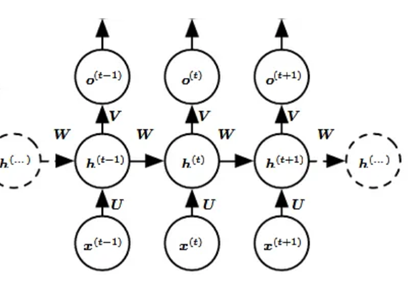







So,we can say:

The `hidden state` represents the network's memory and captures information from previous time steps. This allows the network to retain context and learn patterns across the sequence. h(t)​,in the figure abve, represents a hidden state at time t and acts as “memory” of the network

`Recurrent Connections`: Recurrent connections(the connections with arrows in the figure) connect the hidden state of a cell to itself at the next time step, enabling the network to retain and utilize information across multiple time steps.I will discuss more about the parts later.

##Sequence to Sequence with RNN (baseline)
My goal, in this section, is to implement a machine translation model(seq2seq model) using vanilla RNN.




Vanilla RNN-is the simplest form of RNN which processes input sequences step by step and uses a simple method to update its memory or hidden state. For each piece, it combines the current input with its memory (technically, its 'hidden state') of what it has seen previously in the sequence to make a decision or prediction.It's called 'vanilla' because it's the most basic type of this model.


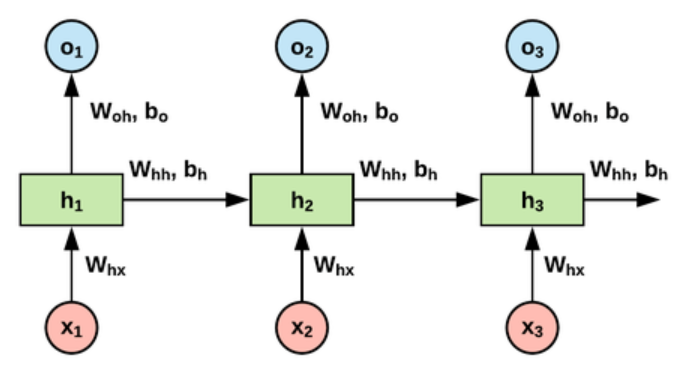


A Seq2Seq model is type of model that turns one sequence, like a sentence in English, into another sequence, like the translated sentence in French.
The model consists of an encoder and a decoder, which work together to translate text from one language to another.




Let me explain purposes of these components:





##3.2. Encoder:
The encoder in machine translation is responsible for understanding and capturing the meaning of the input sentence. It processes the input sentence word by word and converts each word into a meaningful representation that can be understood by the model. The purpose of the encoder is to create a condensed and fixed-length representation of the input sentence that captures its essential information.

Let's take an example to understand this better. Suppose we want to translate the English sentence "I love cats" into French. The encoder's role is to process each word in the input sentence ("I," "love," "cats") and convert them into a meaningful representation. It understands the relationships and context between the words to capture their semantic meaning. For instance, it recognizes that "I" refers to the person speaking, "love" represents a strong positive emotion, and "cats" refers to the animals.
#Embedding
The encoder uses techniques like word embedding to represent each word as a dense vector. Word embedding assigns a unique vector to each word in a way that similar words have similar vectors. For example, the word "love" might be represented by the vector [0.4, 2.5, -0.9,0.5]. By converting words into dense vectors, the encoder can capture their semantic relationships and similarities.


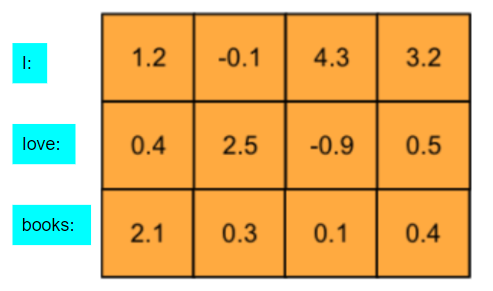

After the input sentence is encoded, the encoder changes the embedding matrix to a fixed-length vector that summarizes the input's important features.


In this case, the fixed-length representation might look like: [0.1, -0.2, 0.3, ..., 0.5] (a 256-dimensional vector).


This fixed-length representation contains condensed information about the input sentence "I love cats" which will then be passed from the encoder to the decoder.

The following code achieves this encoding as follows.

It consists of an embedding layer (self.embedding) and a vanilla RNN (self.enc).

The forward method performs the actual encoding of the input sequence. It takes the input sequence (sources) and the valid length of the sequence `(valid_len)` as inputs.

First, the code passes the input sequence through the embedding layer, converting each word into its dense vector representation (word_embedded). This step allows the encoder to capture the semantic meaning of each word.

Next, the code initializes the hidden state of the RNN (h) with zeros. This hidden state serves as a memory that retains information about the processed words.

Then, the embedded sequence and the hidden state are fed into the RNN `(self.enc)`. The RNN processes the embedded sequence word by word, updating the hidden state at each step. This allows the RNN to capture the contextual information and dependencies between words.

Finally, the code returns the hidden state corresponding to the valid last time step `(o[np.arange(N), valid_len])`

In [ ]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super(Encoder, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim) # embedding layer
    self.enc = nn.RNN(embedding_dim, hidden_size, batch_first=True)
    self.hidden_size = hidden_size

  def forward(self, sources, valid_len):

    word_embedded = self.embedding(sources)

    N = word_embedded.shape[0]

    h = sources.new_zeros(1, N, self.hidden_size).float() # initialize hidden state with zeros

    o, h = self.enc(word_embedded, h)

    return o[np.arange(N), valid_len] # return the hidden state of the valid last time step



## 3.3. Decoder

The decoder in machine translation works in tandem with the encoder to generate the translated output sentence. It takes the fixed-length representation produced by the encoder and uses it as a source of information to generate the translated sentence.

Let's consider the example of translating the English sentence "Hello World" into French. After the encoder produces the fixed-length representation ,[0.1, -0.2, 0.3, ..., 0.5] for example, the decoder takes over
starts generating translated output sentence using this representation as its initial hidden state.


During the decoding process, the decoder uses the above representation and previously generated words as inputs to generate words.When generating words,the decoder will create probability distribution over the whole words in the target vocabulary(the vocabulary we use(French vocabulary,in our case)).By selecting the word with the highest probability from this distribution, it generates the translated words. As you can see from the figure below, to generate the second word 'le', it used the first generated word, 'bonjour' , along with the hidden state generated from the encoder.

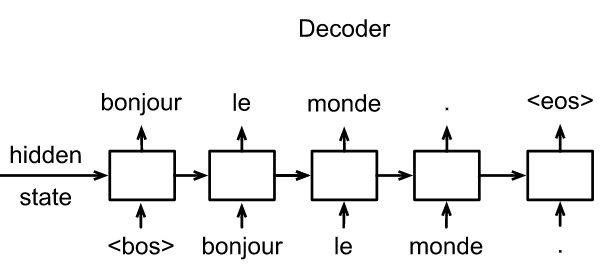

At each step of decoding, the decoder generates a word and updates its hidden state based on the predicted word and the previous hidden state. It continues this process, gradually building the translated sentence word by word.



The code below achieves the task of decoding as follows.

The Decoder class consists of an embedding layer (self.embedding), a vanilla RNN (self.dec), and a linear layer (self.output_emb).

The embedding layer is responsible for converting each word in the translation into its dense vector representation.
`word_embedded = self.embedding(target)`

The RNN processes the embedded translation word by word, updating its hidden state at each step. This hidden state contains the encoded information from the fixed-length representation and serves as a memory for generating the translation. The hidden state, generated by the encoder network and fed into the decoder network, to generate accurate translations.

Finally, the linear layer takes the output of the RNN and maps it to the vocabulary size, producing predictions for each word in the translated sentence.
`pred = self.output_emb(o)`

In [ ]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super(Decoder, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.enc = nn.RNN(embedding_dim, hidden_size, batch_first=True)
    self.output_emb = nn.Linear(hidden_size, vocab_size)
    self.hidden_size = hidden_size

  def forward(self, h, target):
    word_embedded = self.embedding(target)
    N, T = word_embedded.shape[:2]

    o, h = self.enc(word_embedded, h.view(1,N,self.hidden_size))
    pred = self.output_emb(o)
    return pred, h

##3.4. NMTRNN-
 is a model that combines the Encoder and Decoder components we discussed earlier to perform machine translation

During the prediction phase, the NMTRNN model takes an input sentence, encodes it using the Encoder, and generates the translated output sentence step by step using the Decoder. The model predicts the next word based on the previously generated words, gradually constructing the complete translation.

                      The code below achieves this as follows

In the forward method, the Encoder encodes the source sentence `(src)` using the `enc` function and produces a fixed-length representation `(h)`. The Decoder takes this representation and the target sentence `(tgt)` to generate predictions `(pred)` using the `dec` function.


The forward method in the NMTRNN class uses `Teacher-forcing`. During training, the correct previous token (tgt) is passed to the decoder at each time step, allowing it to learn the correct sequence mapping from the source sentence to the target sentence.


The loss function in the model is the negative log likelihood loss. It measures the model's performance on classification tasks where classes are mutually exclusive.

During prediction, the model uses the Encoder to encode the source sentence and initializes the input `(inputs)` with the start-of-sentence token. It iteratively generates predictions for each time step, updating the input based on the previous predictions, until the maximum length `(MAX_LEN)` is reached.



Finally, the model returns the predicted translation `(pred)`for the source sentence.

In [ ]:
class NMTRNN(nn.Module):
  def __init__(self, src_vocab_size, tgt_vocab_size, embedding_dim, hidden_size):
    super(NMTRNN, self).__init__()
    self.enc = Encoder(src_vocab_size, embedding_dim, hidden_size)
    self.dec = Decoder(tgt_vocab_size, embedding_dim, hidden_size)

  def forward(self, src, src_len, tgt, tgt_len):
    h = self.enc(src, src_len)
    T = tgt.shape[1]

    pred, _ = self.dec(h, tgt)

    loss = F.nll_loss(F.log_softmax(pred[:, :T-1].transpose(1,2), dim = 1), tgt[:, 1:], ignore_index=0, reduction = 'none')
    loss = loss.sum(1).mean()

    return loss, pred.argmax(dim=-1)

  def predict(self, src, src_len, tgt, tgt_len):
      h = self.enc(src, src_len)

      inputs = tgt[:, :1]
      preds = []
      for t in range(MAX_LEN+1): # plus the 'eos' token
        pred, h = self.dec(h, inputs)
        preds.append(pred)
        inputs = pred.argmax(dim=-1)

      pred = torch.cat(preds, dim=1).argmax(dim=-1)
      return pred


##3.5. Training

We use this code to plot the values of the weights after each epoch. Sometimes, the weights after each epoch will not change much and are very close with each other as can be seen in the plot after training.


In [ ]:
import matplotlib.pyplot as plt

def plot_weights(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            plt.figure(figsize=(10, 5))
            plt.title(name)
            plt.plot(param.cpu().data.numpy().flatten())
            plt.show()


The following code trains the Neural Machine Translation (NMT) model using RNN. I set up the required hyperparameters, load the training data, create instance of the NMT model, and trains the model using the train_rnn function. The function performs the training loop, computes the loss, updates the model parameters, and returns the loss values. Finally, the resulting loss values are stored in rnn_loss_list.

(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))
iter 0 / 7650	Loss:	32.435062
pred:	 tensor([201, 272, 125, 179, 173,  99, 326, 326, 326, 326])

tgt:	 tensor([3, 5, 2, 0, 0, 0, 0, 0, 0])



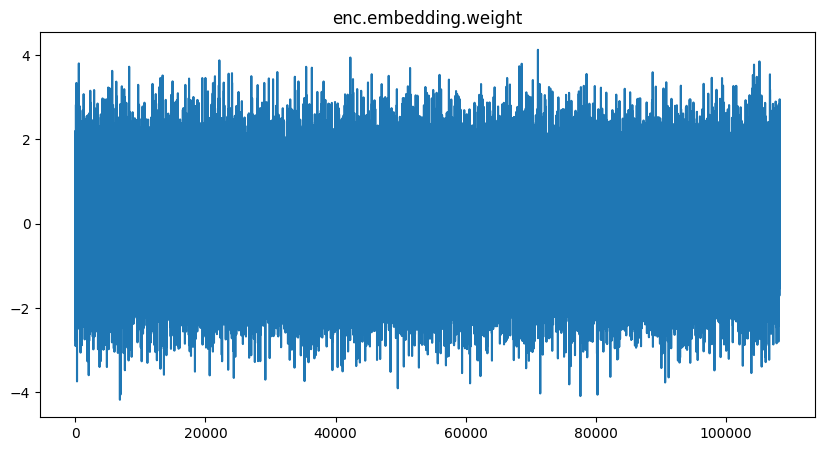

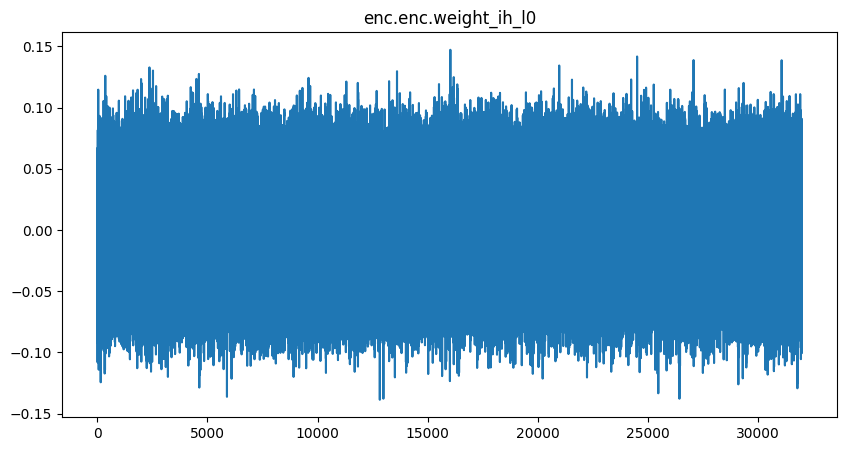

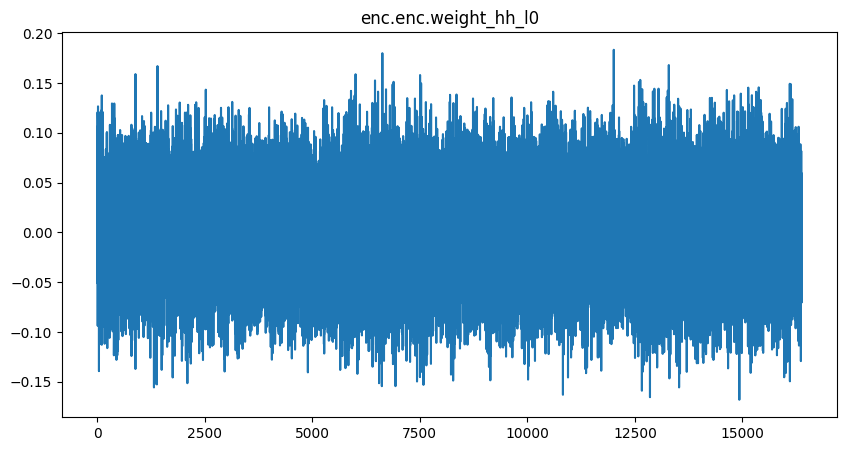

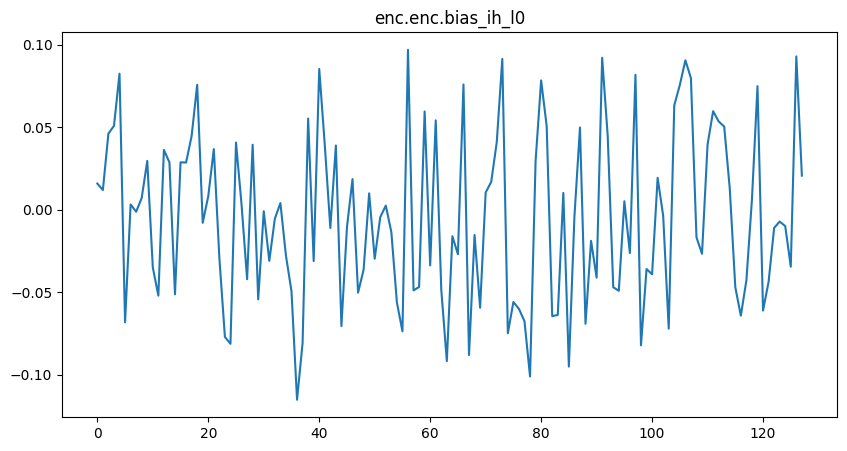

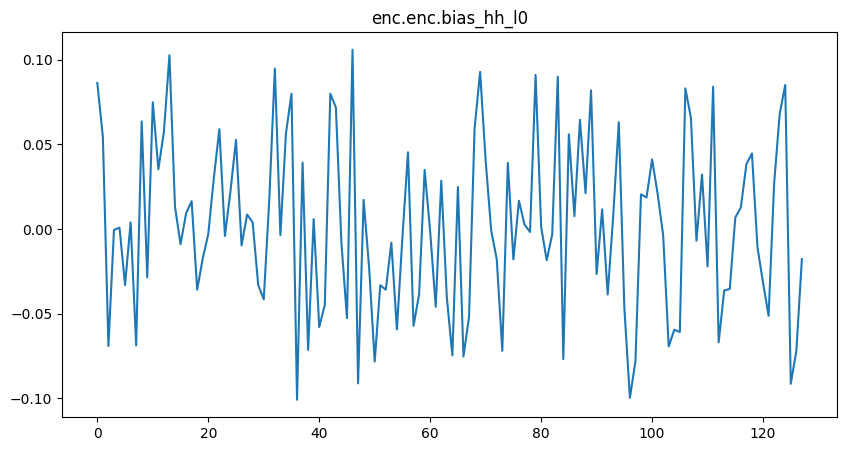

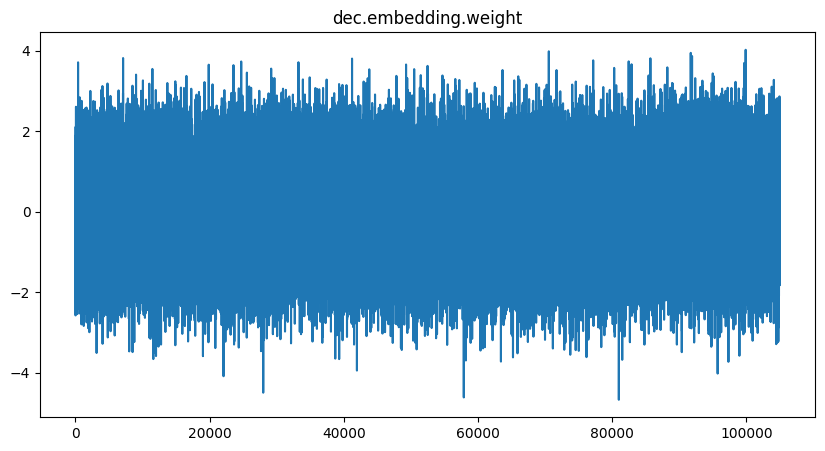

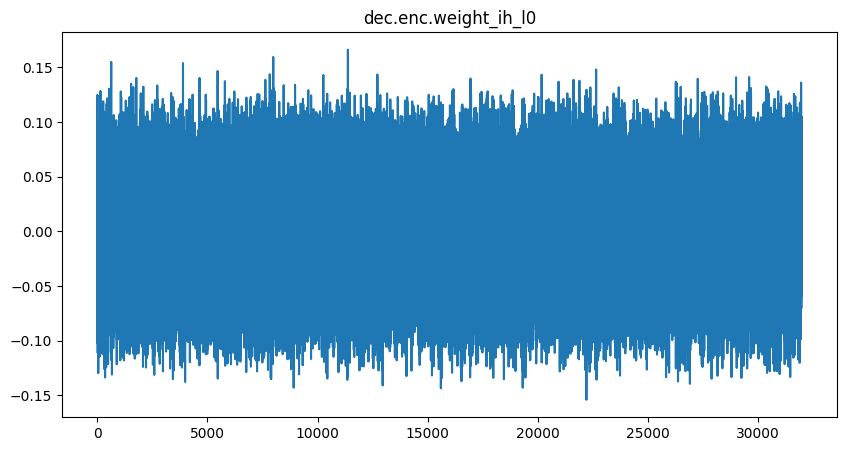

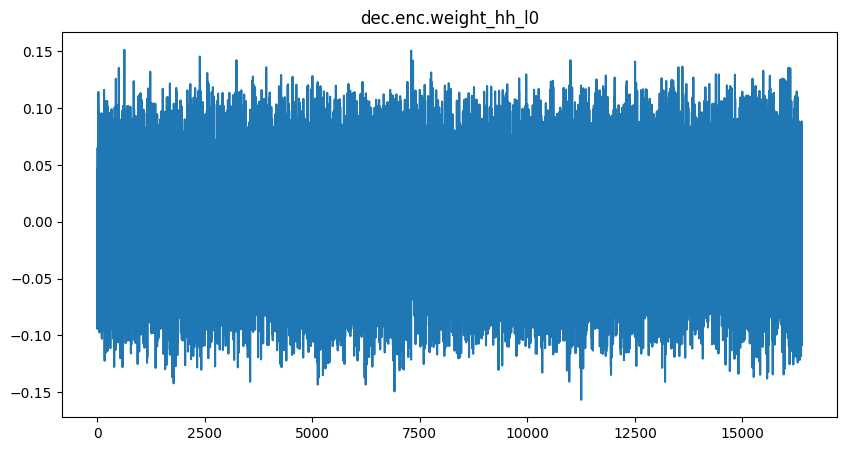

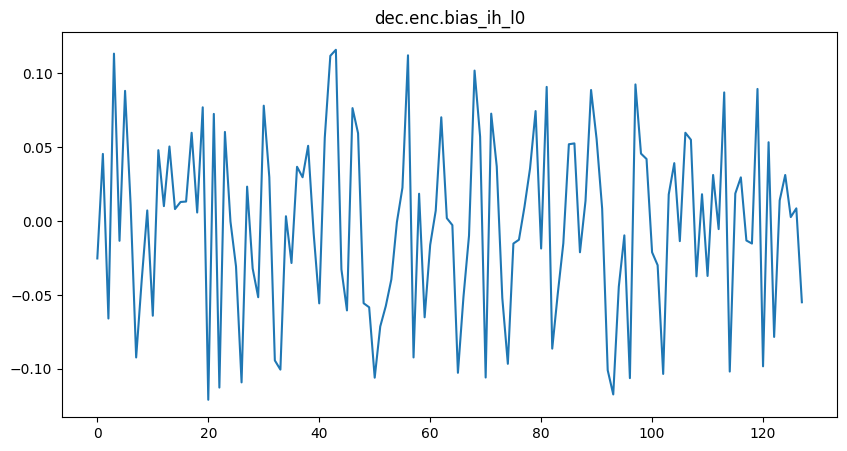

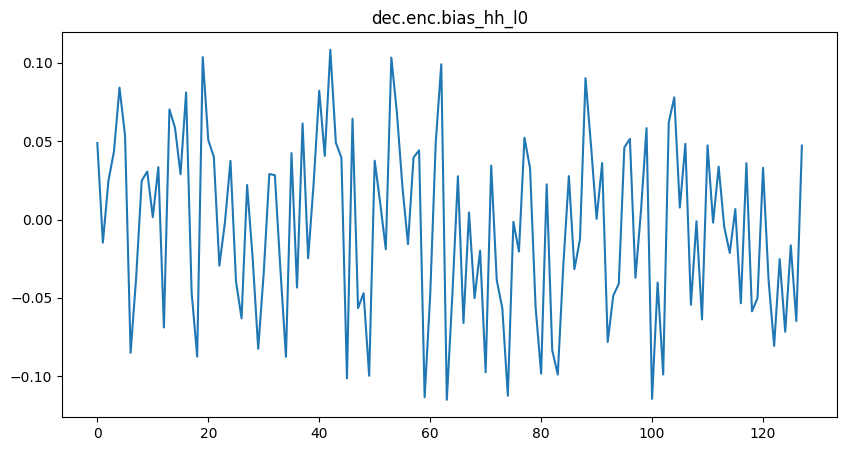

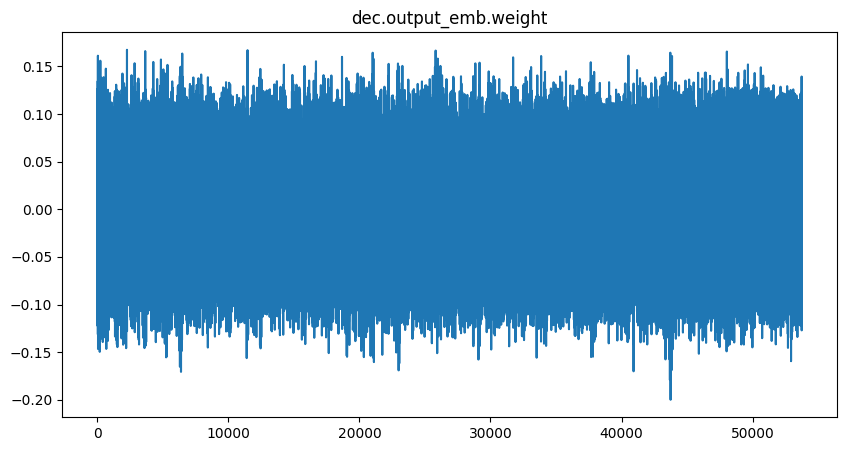

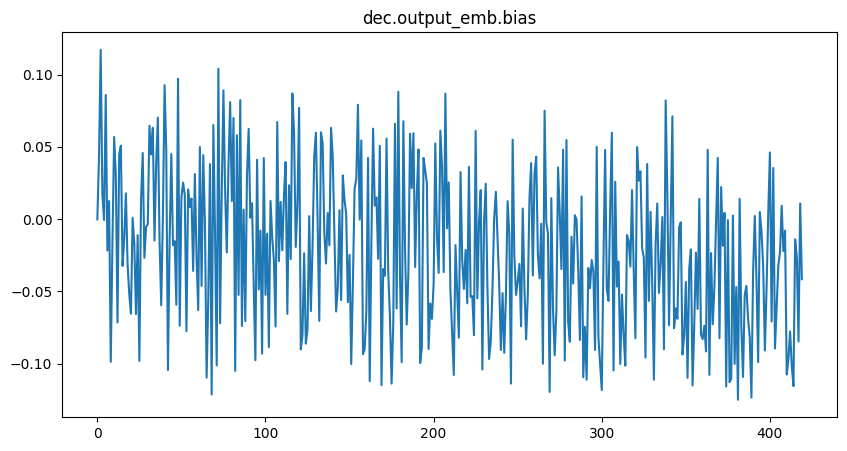

iter 153 / 7650	Loss:	12.019598
pred:	 tensor([ 3,  5,  2, 11, 11, 11, 11, 11, 11, 11])

tgt:	 tensor([3, 5, 2, 0, 0, 0, 0, 0, 0])

iter 306 / 7650	Loss:	10.170216
pred:	 tensor([ 3,  5,  2, 11, 11, 11, 11, 11, 11, 11])

tgt:	 tensor([3, 5, 2, 0, 0, 0, 0, 0, 0])

iter 459 / 7650	Loss:	8.953923
pred:	 tensor([ 3,  5,  2, 11, 11, 11, 11, 11, 11, 11])

tgt:	 tensor([3, 5, 2, 0, 0, 0, 0, 0, 0])

iter 612 / 7650	Loss:	8.088092
pred:	 tensor([ 3,  5,  2,  5, 11, 11, 11, 11, 11, 11])

tgt:	 tensor([3, 5, 2, 0, 0, 0, 0, 0, 0])

iter 765 / 7650	Loss:	7.519693
pred:	 tensor([ 3,  5,  2,  5,  5,  5, 11, 11, 11, 11])

tgt:	 tensor([3, 5, 2, 0, 0, 0, 0, 0, 0])

iter 918 / 7650	Loss:	7.047654
pred:	 tensor([ 3,  5,  2,  5,  5, 11, 11, 11, 11, 11])

tgt:	 tensor([3, 5, 2, 0, 0, 0, 0, 0, 0])

iter 1071 / 7650	Loss:	6.609359
pred:	 tensor([ 3,  5,  2,  5,  5, 11, 11, 11, 11, 11])

tgt:	 tensor([3, 5, 2, 0, 0, 0, 0, 0, 0])

iter 1224 / 7650	Loss:	6.359948
pred:	 tensor([ 3,  5,  2,  5,  5, 11, 11, 11, 1

In [ ]:
seed(1)
import torch
from torch.utils.data import random_split

def train_rnn(net, train_iter, valid_iter, lr, epochs, device):
  # training
  net = net.to(device)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  train_loss_list = []
  valid_loss_list = []
  print_interval = len(train_iter)
  total_iter = epochs * len(train_iter)

  for e in range(epochs):
    net.train()
    epoch_train_loss = 0
    for i, train_data in enumerate(train_iter):
      train_data = [ds.to(device) for ds in train_data]
      loss, pred = net(*train_data)
      epoch_train_loss += loss.mean().item()
      optimizer.zero_grad()
      loss.mean().backward()
      optimizer.step()

      step = i + e * len(train_iter)
      if step % print_interval == 0:
        print('iter {} / {}\tLoss:\t{:.6f}'.format(step, total_iter, loss.mean().detach()))
        print('pred:\t {}\n'.format(pred[0].detach().cpu()))
        print('tgt:\t {}\n'.format(train_data[2][0][1:].cpu()))



    train_loss_list.append(epoch_train_loss / len(train_iter))
    if(e%3725==0):
        plot_weights(net)

    # Validation
    net.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
      for valid_data in valid_iter:
        valid_data = [ds.to(device) for ds in valid_data]
        loss, _ = net(*valid_data)
        epoch_valid_loss += loss.mean().item()

    valid_loss_list.append(epoch_valid_loss / len(valid_iter))

  return train_loss_list, valid_loss_list

#random_seed = 1
#random.seed(random_seed)
#torch.manual_seed(random_seed)
batch_size = 32
lr = 1e-3
epochs = 50

embedding_dim = 250
hidden_size = 128

vocab_eng, vocab_fra, full_iter = load_data_nmt(batch_size)

# split dataset
total_size = len(full_iter.dataset)
train_size = int(total_size * 0.98)
valid_size = total_size - train_size
train_dataset, valid_dataset = random_split(full_iter.dataset, [train_size, valid_size])

# Create new DataLoaders
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
valid_iter = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

rnn_net = NMTRNN(vocab_eng.num_word, vocab_fra.num_word, embedding_dim, hidden_size)

train_loss_list, valid_loss_list = train_rnn(rnn_net, train_iter, valid_iter, lr, epochs, device)


The above plot shows the training loss after selected epochs, predicted and target tensors and also values of weights in the epoch.(Scroll up and down). Note that, Tensors represent words.

### RNN Loss Curve

Plot of the loss curve over epochs.

In [ ]:
!pip install plotly


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import plotly.graph_objects as go

def plot_loss(train_loss_list, valid_loss_list):
    epochs = list(range(1, len(train_loss_list) + 1))

    fig = go.Figure()

    # Add traces
    fig.add_trace(go.Scatter(x=epochs, y=train_loss_list,
                        mode='lines+markers',
                        name='Training Loss'))
    fig.add_trace(go.Scatter(x=epochs, y=valid_loss_list,
                        mode='lines+markers',
                        name='Validation Loss'))

    # Set title and labels
    fig.update_layout(
        title="Training and Validation Loss over Epochs",
        xaxis_title="Epochs",
        yaxis_title="Loss",
        legend_title="Loss Types",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple"
        )
    )

    # Show the plot
    fig.show()

# Call the function to create the plot
plot_loss(train_loss_list, valid_loss_list)


In the above plot, you can hover over the data points and could look at the losses at that specific epoch.

###3.6.  Prediction Accuracy



The following code evaluates the performance of the trained model.


The `evaluate_rnn` function takes the trained NMT model, training data iterator, and device.

The function iterates over the training data, transfers the data to the device, generates predictions using the model's `predict` method, and calculates the prediction accuracy using comp_acc.

The prediction accuracies are stored in `acc_list`, and example predictions and ground truth sequences are printed for the first five batches.

The average prediction accuracy is calculated from `acc_list` and displayed.

In [ ]:
def comp_acc(pred, gt, valid_len):
  N, T_gt = gt.shape[:2]
  _, T_pr = pred.shape[:2]
  assert T_gt == T_pr, 'Prediction and target should have the same length.'
  len_mask = torch.arange(T_gt).expand(N, T_gt)
  len_mask = len_mask < (valid_len - 1)[:, None]

  pred_crr = (pred == gt).float() * len_mask.float() # filter out the 'bos' token
  pred_acc = pred_crr.sum(dim=-1) / (valid_len - 1).float() # minus the 'bos' token
  return pred_acc

def evaluate_rnn(net, valid_iter, device):
  acc_list = []
  for i, valid_data in enumerate(valid_iter):
    valid_data = [ds.to(device) for ds in valid_data]

    pred = net.predict(*valid_data)

    pred_acc = comp_acc(pred.detach().cpu(), valid_data[2].detach().cpu()[:, 1:], valid_data[3].cpu())
    acc_list.append(pred_acc)
    if i < 5:# print 5 samples from 5 batches
      pred = pred[0].detach().cpu()
      pred_seq = []
      for t in range(MAX_LEN+1):
        pred_wd = vocab_fra.index2word[pred[t].item()]
        if pred_wd == 'eos':
          break

        pred_seq.append(pred_wd)

      print('pred:\t {}\n'.format(pred_seq))
      print('tgt:\t {}\n'.format([vocab_fra.index2word[t.item()] for t in valid_data[2][0][1:].cpu()]))

  print('Prediction Acc.: {:.4f}'.format(torch.cat(acc_list).mean()))


seed(1)
#random.seed(seed)
#torch.manual_seed(seed)
batch_size = 32

vocab_eng, vocab_fra, full_iter = load_data_nmt(batch_size)


print()
print('Prediction of training dataset shown below:')
print()
evaluate_rnn(rnn_net, train_iter, device)
print()
print('Prediction of validation dataset shown below:')
print()
evaluate_rnn(rnn_net, valid_iter, device)


(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))

Prediction of training dataset shown below:

pred:	 ['va', 'voir', 'unk', 'si', "j'y", 'suis', '!']

tgt:	 ['unk', '!', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']

pred:	 ['continuez', 'à', 'courir', '.']

tgt:	 ['continue', 'à', 'courir', '.', 'eos', 'pad', 'pad', 'pad', 'pad']

pred:	 ['pouvons-nous', 'parler', '?']

tgt:	 ['unk', "s'en", 'aller', '?', 'eos', 'pad', 'pad', 'pad', 'pad']

pred:	 ["c'est", 'unk', '.']

tgt:	 ["c'est", 'du', 'unk', 'tout', 'ça', '.', 'eos', 'pad', 'pad']

pred:	 ['je', 'suis', 'unk', 'à', 'toi', '.']

tgt:	 ["j'y", 'suis', 'unk', 'deux', 'fois', '.', 'eos', 'pad', 'pad']

Prediction Acc.: 0.6672

Prediction of validation dataset shown below:

pred:	 ["j'ai", 'des', 'unk', '.']

tgt:	 ["j'ai", 'des', 'unk', '.', 'eos', 'pad', 'pad', 'pad', 'pad']

pred:	 ['je', 'unk', '.']

tgt:	 ['je', 'vous', 'unk', '.', 'eos', 'pad', 'pad', 'pad', 'pad']

pred

The above result shows the model predictions and what our targets were. We have got prediction accuracy of 55.18% in validation data which is fairly high given that machine translation is one of the hardest even compared with other deep learning tasks. Next, we will modify our model using LSTM and Attention.

##4) **The Second Implementation**- Incorporating LSTM and attention to vanilla RNN

**` Sequence to Sequence with LSTM and Attention`**

Now let's try to improve our model by using an LSTM and the attention mechanism.




`Seq2Seq with LSTM and Attention` is an advanced model architecture that enhances the basic `Seq2Seq with RNN (baseline)` model. Here's a description highlighting the differences between the encoder and decoder in both models:

In the baseline `Seq2Seq model with RNN`, the encoder and decoder are composed of simple RNN cells.The limitation of the basic RNN is its difficulty in capturing `long-term dependencies` effectively. It tends to suffer from `vanishing or exploding gradients`, making it challenging to encode and decode sequences accurately.

To address this limitation, `Seq2Seq with LSTM and Attention` incorporates Long Short-Term Memory (LSTM) cells in both the encoder and decoder. The addition of attention mechanism allows the decoder to dynamically focus on different parts of the input sequence.



##**`4.2. LSTM Structure`**

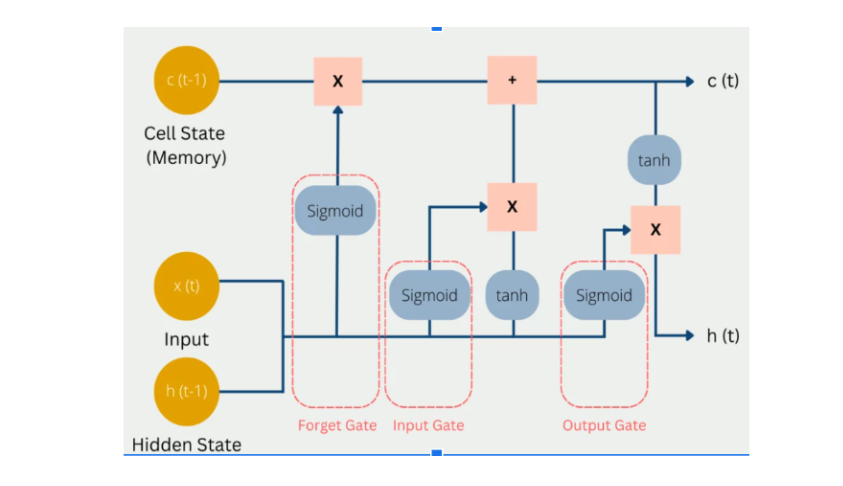

Firstly, recall RNNs (both LSTM and a vanilla RNN) have this kind of structure when unrolled.

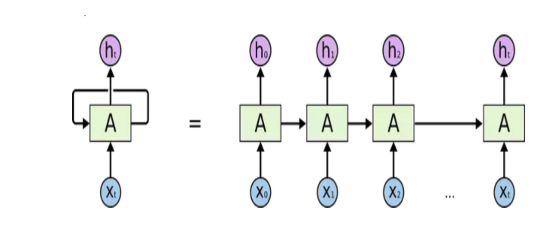

Basically, we are feeding in a sequence of inputs. The hope is that the states of the “cell” contains information from all of the inputs that have been fed in up to that point i.e all of the Xs that have been fed in have a say in the state of A. Think of it like A is supposed to listen to, more or less, every one of the Xs.

Now, in the vanilla RNN, the internal of the cell is this:

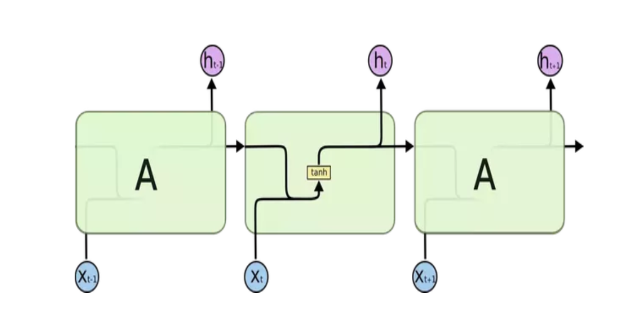

Imagine a messenger taking information from the first cell to the last. It first “listens” to X0 and then listens to X1 and so on till it reaches the last state.

X0: “Hey A! *Important info*”

A: “Okay. Got it.”

X1: “Hey A! *Irrelevant info*”

A: “Sure.”

X2: “Hey A! *Important info*”

A: “Okay.”

….

So, in all likelihood, it mostly just remembers what the later Xs said i.e the things said by the Xs at the start of the sequence have little to no influence on what A remembers at the end.

That is a problem because it means the network doesn’t take long(er) dependencies into account. So, here, A might have completely forgotten what X0 had said!

LSTM tries to prevent that.

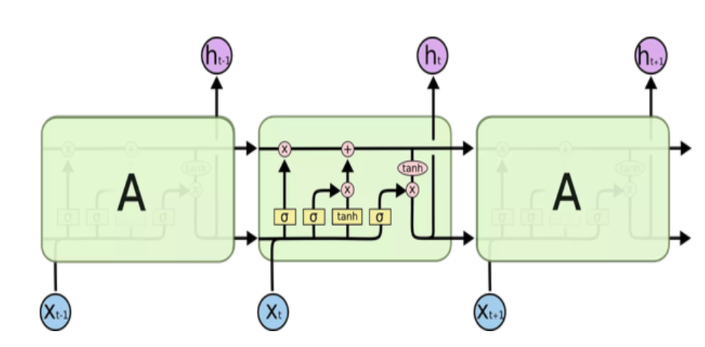

Looks complicated but the main part is the upper line.

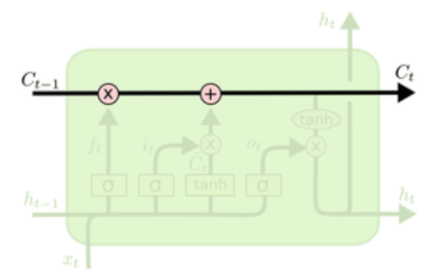

Basically there’s an information highway that goes through the network which is gated. So, instead of just adding in the information gained when listening to each X, it is more “selective” about what it chooses to forget from its memory, what it listens to and what information it adds to its (long-term) memory.

The way LSTM selects information is by using gates.

Let's take the sentence 'The person, who is graduated from KAIST and met with his friends to have fun, is brilliant' as an example and look at what each gate does.

                                   Input Gate:

The input gate manages the input information and decides what input to store in the memory cell and what to discard.


                                  Forget Gate:

The forget gate manages the retention or forgetting of memory contents(stored).


                                   Output Gate:

The output gate manages the exposure of the memory cell content as the output of the LSTM unit.
In our example sentence, as the LSTM unit generates the output, the output gate determines how much of the memory cell's information should be included in the final output.

It decides which parts of the stored information, such as the person's interaction with friends, contribute to the understanding of the word,for example, 'brilliant' mentioned in the sentence.

LSTM's state and gate update at each time step can be summarized as follows:

$$
\begin{align*}
&\text{State Update} &&& C_t &= F_t \odot C_{t-1} + I_t \odot \tilde{C}_t \\
&\text{Hidden States} &&& H_t &= O_t \odot \text{tanh}(C_t) \\
&\text{Proposal} &&& \tilde{C}_t &= \text{tanh}( X_tW_{xc} + H_{t-1}W_{hc} + b_c ) \\
&\text{Input Gate} &&& I_t &= \sigma( X_tW_{xi} + H_{t-1}W_{hi} + b_i ) \\
&\text{Forget Gate} &&& F_t &= \sigma( X_tW_{xf} + H_{t-1}W_{hf} + b_f ) \\
&\text{Output Gate} &&& O_t &= \sigma( X_tW_{xo} + H_{t-1}W_{ho} + b_o ) \\
\end{align*}
$$






**The code,after the following description, implements an `LSTM` module from scratch without using `nn.lstm`.**

The following is the explanation of the "LSTM" function in the implementation. It is where most of the work is done.


`lstm(self, X, state)`:

**Input Preparation:**

The lstm function receives two inputs: X (the input sequence) and state (the initial hidden state and cell state).
The input sequence, X, is unpacked into src (the source input) and src_len (the valid length of each input).

**LSTM Forward Pass:**

The LSTM forward pass processes the input sequence step by step to generate outputs and update the hidden state and cell state.
Looping over the Time Steps:


**Computing LSTM Gates:**

The function loops over each time step, from 0 to T (the length of the input sequence).

At each time step, the function computes four gates: forget gate (F), input gate (I), cell gate (C), and output gate (O).
These gates are calculated based on the current input (x_t), the previous hidden state (h), and the parameters (W_xf, W_hf, b_f, W_xi, W_hi, b_i, W_xc, W_hc, b_c, W_xo, W_ho, b_o).

**Updating Cell and Hidden States:**

Using the gate values, the function updates the cell state (c) and hidden state (h) at each time step.
The forget gate determines how much of the previous cell state should be forgotten, while the input gate controls how much new information is added to the cell state.
The output gate regulates the flow of information from the updated cell state to the hidden state.

**Validity Check:**

A validity mask is used to ensure that only valid input elements are processed by the LSTM.
The mask is created based on the valid lengths of the input sequence, ensuring that padding tokens are not considered in the updates.


**Generating Outputs:**

At each time step, the function appends the current hidden state (h) to the output list (o).

The output list is stacked to create a tensor of shape (N, T, hidden_size), where N is the batch size, T is the length of the input sequence, and hidden_size is the dimension of the hidden state.
The final hidden state (h) and cell state (c) are stored in the state variable.

**Returning Outputs and State:**

The function returns the output tensor (o) and the updated state (state), which contains the final hidden state and cell state.







....

**Please take a deep look at the following code. It is implementation of LSTM from Scratch**

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, device):
    super(LSTM, self).__init__()
    self.device = device
    self.params = nn.ParameterList(self.init_params(input_size, hidden_size))


  def init_params(self, input_size, hidden_size):

    W_xc, W_hc, b_c = None, None, None
    W_xi, W_hi, b_i = None, None, None
    W_xf, W_hf, b_f = None, None, None
    W_xo, W_ho, b_o = None, None, None


    W_xc, W_hc, b_c = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1), nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1), nn.Parameter(torch.zeros(hidden_size))
    W_xi, W_hi, b_i = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1), nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1), nn.Parameter(torch.zeros(hidden_size))
    W_xf, W_hf, b_f = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1), nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1), nn.Parameter(torch.zeros(hidden_size))
    W_xo, W_ho, b_o = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1), nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1), nn.Parameter(torch.zeros(hidden_size))

    params = [W_xc, W_hc, b_c, W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o]
    return params


  def lstm(self, X, state):

    src, src_len = X
    h, c = state

    # make sure always has a T dim
    if len(src.shape) == 2:
      src = src.unsqueeze(1)

    N, T, D_in = src.shape
    W_xc, W_hc, b_c, W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o = self.params
    o = []

    # The forward pass of the LSTM. LSTM must not be updated by
    # unvalid inputs (padding tokens). In other words, LSTM should be updated only when
    # valid words come in. For example, if input sequence is [4, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    # only input '4' and '5' should be passed to LSTM cell.

    # t:    0           1           2           3           4                   10
    # lstm: h0, c0  >>  h1, c1  >>  h2, c2  >>  h2, c2  >>  h2, c2  >>  ...  >> h2, c2
    #                |           |
    # input:        '4'         '5'

    for t in range(T):

      x_t = src[:, t, :] # (N, D_in)
      F = torch.sigmoid(x_t @ W_xf + h @ W_hf + b_f)
      I = torch.sigmoid(x_t @ W_xi + h @ W_hi + b_i)
      C = torch.tanh(x_t @ W_xc + h @ W_hc + b_c)
      O = torch.sigmoid(x_t @ W_xo + h @ W_ho + b_o)



      # For validity check. (N,)
      valid_mask = (src_len > t).float()[:, None]


      update_c = F * c + I * C
      update_h = O * torch.tanh(c)

      # only update when valid
      c = ((1 - valid_mask) * c) + (valid_mask * update_c)
      h = ((1 - valid_mask) * h) + (valid_mask * update_h)

      o.append(h)

    o = torch.stack(o, dim = 1)

    state = (h, c)
    return o, state




  def forward(self, inputs, state):
    return self.lstm(inputs, state)

-**Masked softmax**

For our machine translation task, the inputs and outputs may be of variable length (i.e. each training example may have a different number of words). As shown above, we pad our inputs with a special `pad` token so that they all have the same length to make them easier to work with. However, when we take the softmax, we only want to include the non-`pad` items, so we need to write a special `masked_softmax` function to handle this. We can achieve the masking by setting masked elements to a large negative value. Then when we take the `exp`, those elements will be 0 and won't contribute to the softmax.


In [ ]:
def masked_softmax(X, valid_length):

  mask_value = -1e7

  if len(X.shape) == 2:
    X = X.unsqueeze(1)

  N, n, m = X.shape

  if len(valid_length.shape) == 1:
    valid_length = valid_length.repeat_interleave(n, dim=0)
  else:
    valid_length = valid_length.reshape((-1,))

  mask = torch.arange(m)[None, :].to(X.device) >= valid_length[:, None]
  X.view(-1, m)[mask] = mask_value

  Y = torch.softmax(X, dim=-1)


  return Y

### 4.3. Attention Mechanism

One way to enhance our model is by incorporating the Attention Mechanism on the LSTM architecture.

The inclusion of attention mechanisms can significantly improve model performance by allowing it to selectively focus on relevant information, even if it is located far away in the input sequence. By integrating attention mechanisms, the model gains the capability to "attend" to specific segments of the input sequence during the output generation process.

- **Mathematically,**

  Given a query, $\mathbf{q} \in R^{d_q}$, and a set of $N$ (key, value) pairs, $\{\mathbf{k}_i, \mathbf{v}_i\}^N $ where $\mathbf{k}_i \in R^{d_k}$ and $\mathbf{v}_i \in R^{d_v}$, the attention mechanism computes a weighted sum of values based on the normalized score obtained from the query and each key:

    \begin{align*}
    a_i &= \alpha(\mathbf{q}, \mathbf{k_i}) \\
    \mathbf{a} &= [a_1, ..., a_n] \\
    \mathbf{b} &= \text{softmax}(\mathbf{a}) \\
    \mathbf{o} &= \mathbf{b} \cdot \mathbf{V}\text{, where } \mathbf{V} = \{\mathbf{v}_i\}^N
    \end{align*}

  The $\alpha()$ function, which maps two vectors into a scalar, is the score function that can be chosen from a wide range of functions: e.g. the cosine function, dot-product function, scaled dot-product funtion and etc.


- **Scaled Dot Product Attention**
    - The scaled dot-product attention uses the score function as:
  $\alpha(\mathbf{q}, \mathbf{k}) = \mathbf{q} \mathbf{k}^T / \sqrt{d}$, where $d$ is the dimension of query (which in this case is equal to the dimension of the keys). The following figures visualizes this process in matrix form, in which $Q \in \mathcal{R}^{m\times d_k}, \mathbf{K} \in \mathcal{R}^{n \times d_k}$, and $\mathbf{V} \in \mathcal{R}^{n \times d_v}$.

    <div>
    <img src="http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png" width="600"/>
    </div>
Image source: http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png


Implementation of the DotProductAttention is below.

In [ ]:
class DotProductAttention(nn.Module):
  def __init__(self):
      super(DotProductAttention, self).__init__()

  def forward(self, query, key, value, valid_length=None):

    attention = masked_softmax((query @ key.permute(0, 2, 1))/(key.shape[1] ** 0.5), valid_length) @ value
    return attention

### LSTM Encoder-Decoder


**4.3 Encoder with LSTM Incorporated**

Let's consider the example sentence "I love cats". As in previous examples,The Encoder processes this input sentence word by word and converts each word into a meaningful representation.
 For instance, the word "love" might be represented by a vector [0.2, -0.3, 0.5] in an embedding space of dimensionality 3.

Next, the LSTM component of the encoder takes these embedded vectors as input and processes the sequence step by step. It captures the sequential information and updates its hidden state accordingly. The outputs of the LSTM are the hidden states for each time step. These hidden states are stored at each step so that the decoder could use them later. In the vanilla RNN we see previously, hidden states of each time step **are not stored**, only the last hidden state will be sent to the decoder.

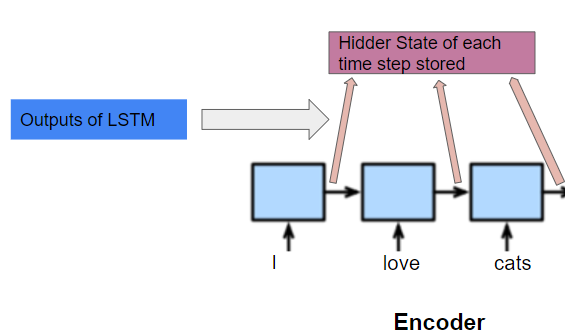



The Encoder module below, incorportes the LSTM I implemented above.The LSTM is represented by the self.enc attribute of the Encoder class. In the forward method, the input sequences are first embedded into a continuous representation using an Embedding layer. These embedded sequences are then passed into the LSTM.

The LSTM processes the input data and returns its outputs along with its final hidden and cell states.

In [ ]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, device):
    super(Encoder, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.enc = LSTM(embedding_dim, hidden_size, device)
    self.hidden_size = hidden_size

  def forward(self, sources, valid_len):
    ##############################################################################
    #  Implementation of LSTM Encoder forward pass
    ##############################################################################


    word_embedded = self.embedding(sources) # (N, T, emb_dim)
    N = word_embedded.shape[0]
    # initialize the hidden state of LSTM
    h = sources.new_zeros(N, self.hidden_size).float() # (N, hidden_size)
    # initialize the memory state of LSTM
    c = sources.new_zeros(N, self.hidden_size).float() # (N, hidden_size)
    #forward propagation of LSTM -> inputs are (X, State)
    outputs, (h, c) = self.enc((word_embedded, valid_len), (h, c))


    return outputs, (h, c)

## 4.5 **Decoder with Attention Incorporated**




Now we want to add attention to the seq2seq model. Attention allows the decoder to have more direct access to previous states in the encoder. In the context of machine translation, when the decoder is predicting a word in the translation, it can focus on certain words in the original language.

Here is the difference between LSTM and Attention: LSTM allows the model to memorize longer sequence while generating translations, while Attention helps the model to focus(give more weight) to a word(some words) among the words that are memorized(by LSTM).

To illustrate the impact of attention mechanisms, consider the example depicted in the accompanying image.




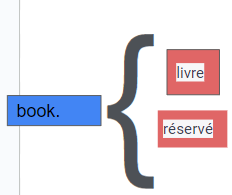

Let's consider the translation of the sentence "The person who is graduated from KAIST buys a book" to French. In French, the word "book" can be translated as either "livre" (referring to a literary work or novel) or "réservé" (referring to a reservation). This  challenges Seq2Seq model without attention mechanism, as it may struggle to choose the correct translation among the two options.

However, when we include attention mechanism to our model, when translating the word "book" to French, the attention mechanism allows the model to focus on specific words that provide clearer indications of its intended translation. In this case, the model assigns a higher attention weight of 0.5 to the word "buy" (as shown below), enabling it to accurately select the appropriate French translation for the word "book".


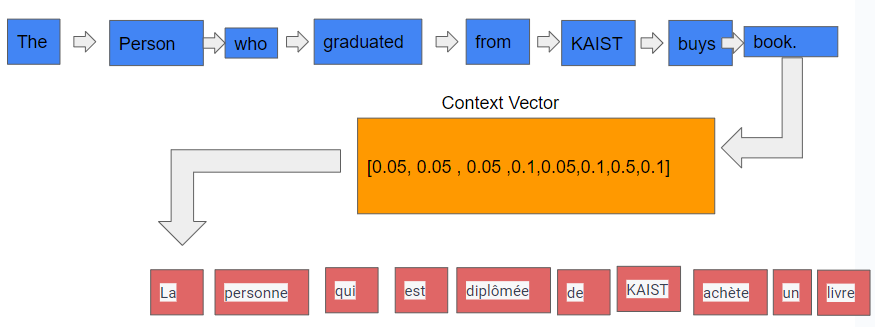









In the code below, The Decoder class utilizes LSTM and attention mechanisms to decode input sequences and generate predictions. It takes inputs such as vocabulary size, embedding dimension, hidden size, and device. The forward method processes the inputs step by step, calculating attention weights and updating the hidden state using LSTM. Predictions are obtained by passing the outputs through a linear layer. The predict method generates predictions using teacher-forcing, updating inputs based on previous predictions.


`Attention Mechanism`: At each time step, the Decoder module applies attention to the hidden states of the encoder (key and value),the previous hidden state of the decoder(query). This generates a context vector that represents the relevant information from the input sequence.
 `context= self.att(h.unsqueeze(1), enc_outputs, enc_outputs, valid_len)`

This then will be concatenated with the decoder's input(previous generated word).
`decoder_input = torch.cat([context, x.unsqueeze(1)], dim=2)`.
This whole combination is decoder's input.

`Output Generation`: The LSTM decoder generates output at each time step based on the hidden state. These outputs are actually tensors,which I mentioned as generated words in previous explanations. These tensors will be passed through a linear layer and transformed into a probability distribution over the target vocabulary.


The Decoder class below incorporates both an LSTM and an attention mechanism.The LSTM is implemented via the self.enc attribute in the Decoder class. The attention mechanism is represented by self.att, which is an instance of a DotProductAttention class.

In [ ]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, device):
    super(Decoder, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of vallina RNN
    """

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.enc = LSTM(embedding_dim+hidden_size, hidden_size, device)
    self.att = DotProductAttention()
    self.output_emb = nn.Linear(hidden_size, vocab_size)
    self.hidden_size = hidden_size

  def forward(self, state, target, valid_len):

    loss = 0
    preds = []
    ##############################################################################
    #  Implementation of LSTM Decoder forward pass.
    #
    #
    # Since using attention mechanism is what I want and this attention needs previous hidden state,
    # I cannot calculate all time-step's prediction at once (parallely).
    # Therefore, I  use a for-loop to obtain preds step by step.
    ##############################################################################


    enc_outputs, (h, c), src_len = state # h = c = (N, hidden_size)
    word_embedded = self.embedding(target) # (N, T, emb_dim)
    N, T, emb_dim = word_embedded.shape
    output_list = torch.zeros((N, T, self.hidden_size)).to(device)
    for t in range(T): #word_embedded[:, t, :] -> (N, emb_dim)
      x = word_embedded[:, t, :] # (N, emb_dim) -> (N, 1, emb_dim)
      context= self.att(h.unsqueeze(1), enc_outputs, enc_outputs, valid_len) # (N, 1, hidden_size)
      ####################

      #################
      decoder_input = torch.cat([context, x.unsqueeze(1)], dim=2) # (N, 1, emb_dim+hidden_size)
      outputs, (h, c) = self.enc((decoder_input, valid_len), (h, c)) #outputs -> (N, 1, hidden_size)
      output_list[:, t, :] = outputs.squeeze(1)
    preds = self.output_emb(output_list) # (N, T, vocab_size)
    loss = F.nll_loss(F.log_softmax(preds[:, :T-1].transpose(1,2), dim = 1), target[:, 1:], ignore_index=0, reduction = 'none')
    loss = loss.sum(1).mean()
    preds = preds.argmax(dim=-1)


    return loss, preds

  def predict(self, state, target, valid_len):
    pred = None
    ##############################################################################
    #  Implementation of LSTM Decoder prediction. I used
    # self.att for attention.
    #
    # 1. Since attention mechanism needs previous hidden state,
    #I used a for-loop to obtain preds step by step.
    #
    # 2. Predict funtion is a little different from Forward function. (Teacher Forcing)
    # you can find this kind of difference from the baseline code as well.
    ##############################################################################


    enc_outputs, (h, c), src_len = state
    word_embedded = self.embedding(target)  #target -> (N, T, vocab_size) -> (N, T, emb_dim)
    # #target -> (N, T), (N, vocab_size), (T, vocab_size)
    (N, T) = target.shape
    inputs = word_embedded[:, :1, :] # target #(N, 1, emb_dim)
    preds = []
    for t in range(T):
      context = self.att(h.unsqueeze(1), enc_outputs, enc_outputs, valid_len) # (N, 1, hidden_size)
      decoder_input = torch.cat([context, inputs], dim=2) # (N, 1, hidden_size+emb_dim)
      outputs, (h, c) = self.enc((decoder_input, valid_len), (h, c)) #src_len/valid_len -> check
      pred = self.output_emb(outputs) # (N, 1, hidden_size) -> (N, 1, vocab_size)
      preds.append(pred)
      inputs = self.embedding(pred.argmax(dim=-1))
    pred = torch.cat(preds, dim=1).argmax(dim=-1) #(N, T, hidden_size) -> (N, T)
    pred = pred[:, :-1]



    return pred



The following code is  implemntation using an `LSTM-based encoder-decoder architecture` that we built above. It takes `source` and `target` sequences and translates the source sequence to the target sequence using an encoder and a decoder. The `forward` method computes the `loss` and generates `predictions`, while the `predict` method focuses on prediction generation without computing the loss.

In [ ]:
class NMTLSTM(nn.Module):
  def __init__(self, src_vocab_size, tgt_vocab_size, embedding_dim, hidden_size, device):
    super(NMTLSTM, self).__init__()
    self.enc = Encoder(src_vocab_size, embedding_dim, hidden_size, device)
    self.dec = Decoder(tgt_vocab_size, embedding_dim, hidden_size, device)

  def forward(self, src, src_len, tgt, tgt_len):
    outputs, (h, c) = self.enc(src, src_len)
    loss, pred = self.dec((outputs, (h, c), src_len), tgt, tgt_len)
    return loss, pred

  def predict(self, src, src_len, tgt, tgt_len):
    outputs, (h, c) = self.enc(src, src_len)
    pred = self.dec.predict((outputs, (h, c), src_len), tgt, tgt_len)
    return pred


##4.6 Training

Finally, I have completed building the LSTM-based model. Now is the time to train it.
In the following code, I used the `train_lstm` function to iterate over the training data and optimize the model's parameters using the `Adam optimizer`. The `loss` and `predictions` are recorded during training. The model is initialized with specified dimensions for embedding and hidden layers. The training is performed for a specified number of epochs, and the recorded loss values are stored in `lstm_loss_list`.(The code may take some minutes running.Please wait!)

(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))
iter 0 / 7450	Loss:	31.941982
pred:	 tensor([291, 276, 312, 282, 361, 293, 293, 349, 349, 349])

tgt:	 tensor([3, 5, 2, 0, 0, 0, 0, 0, 0])



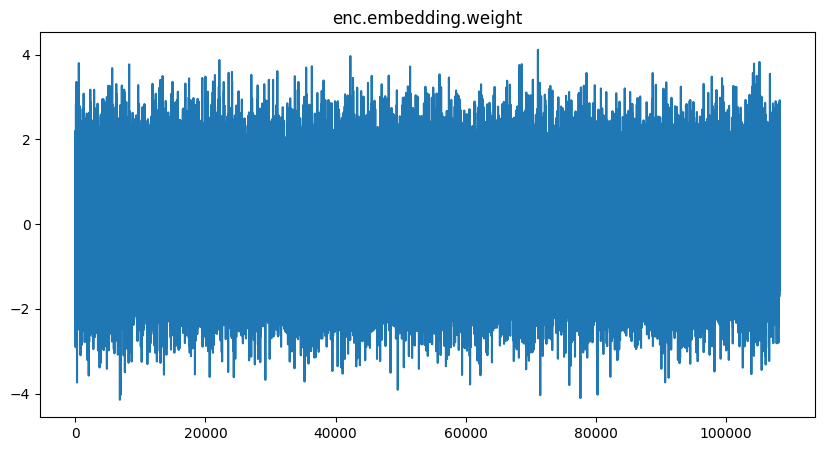

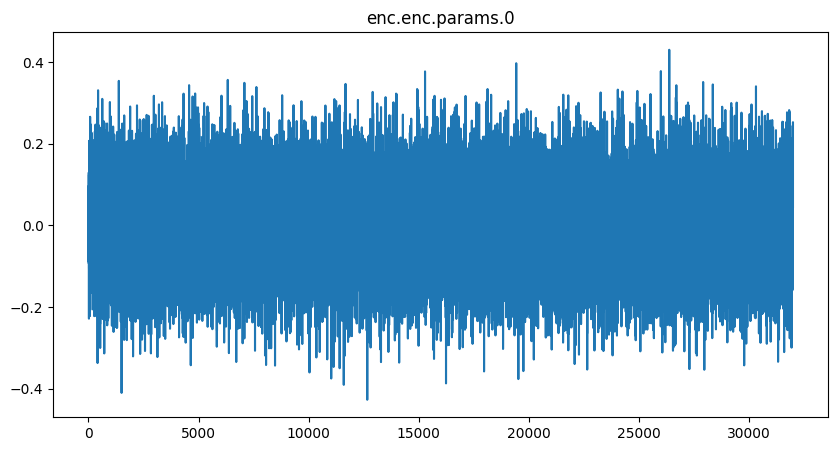

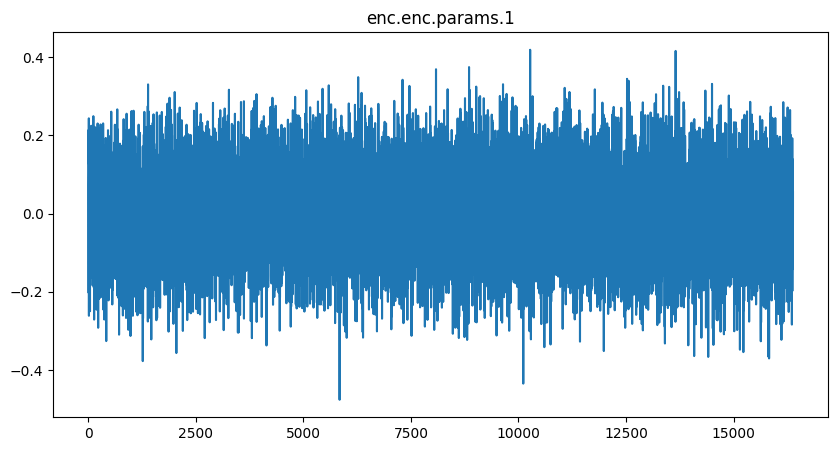

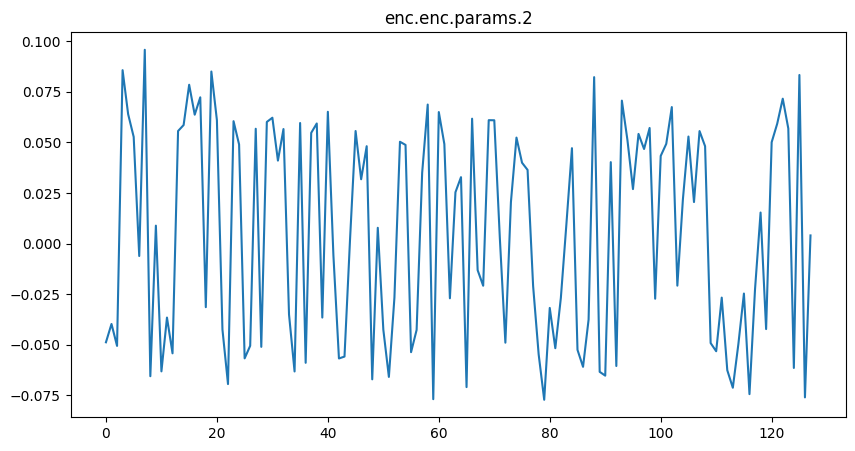

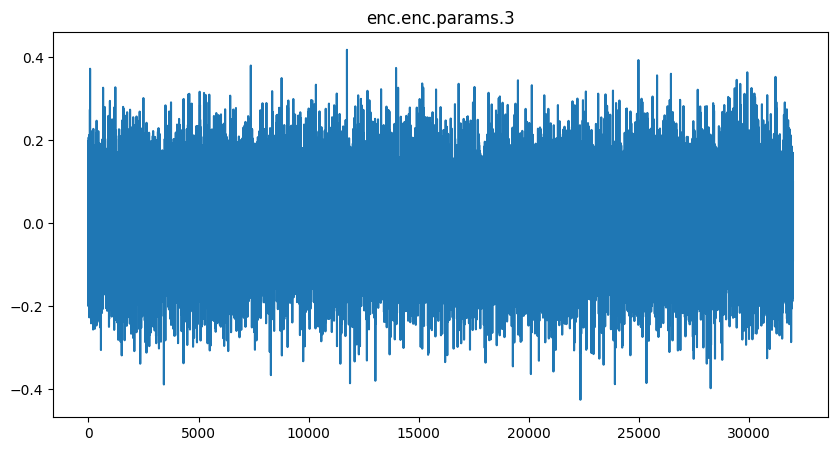

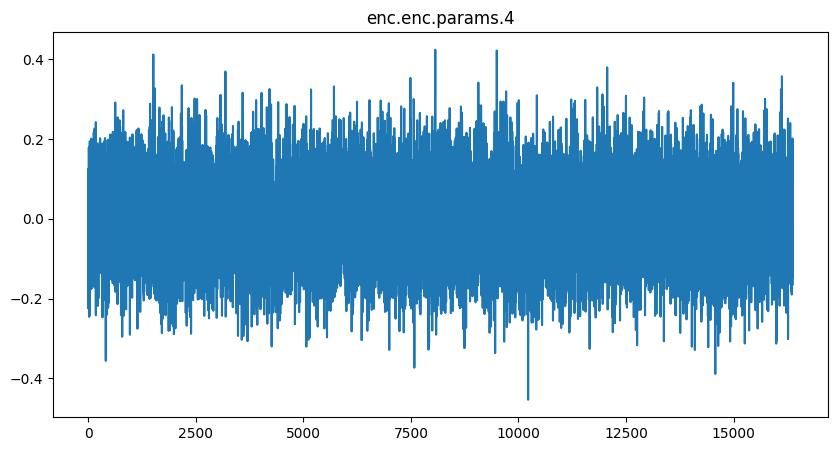

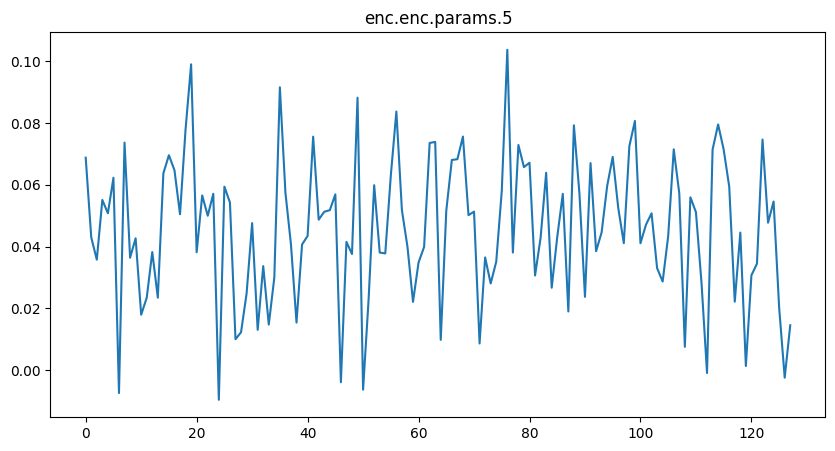

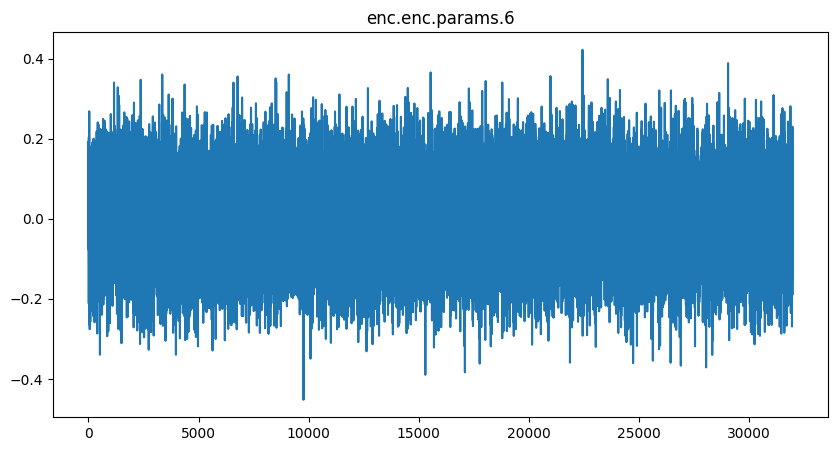

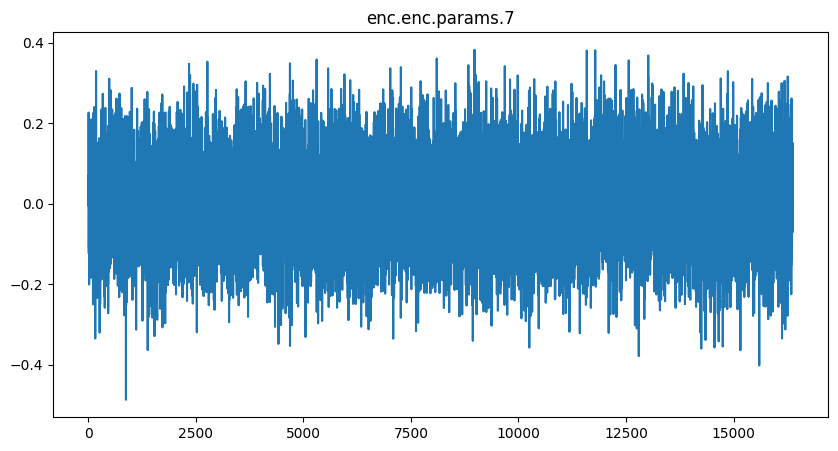

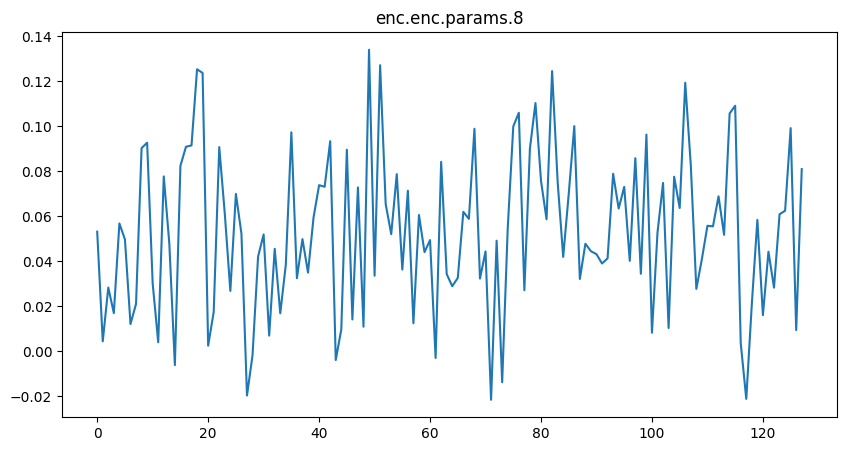

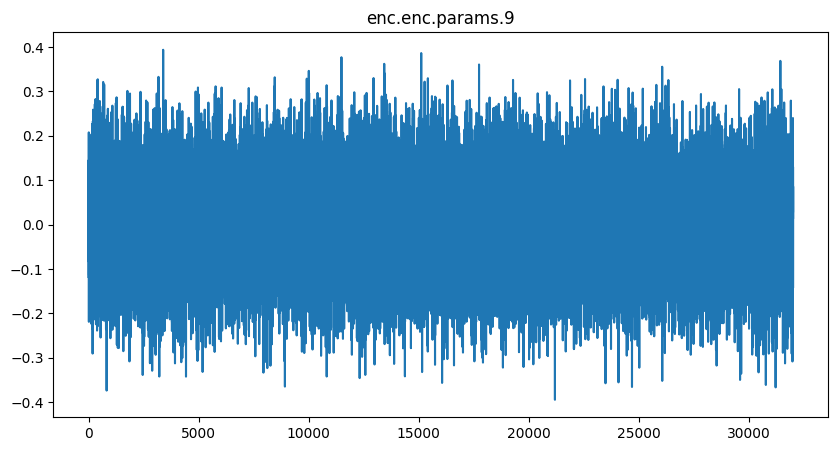

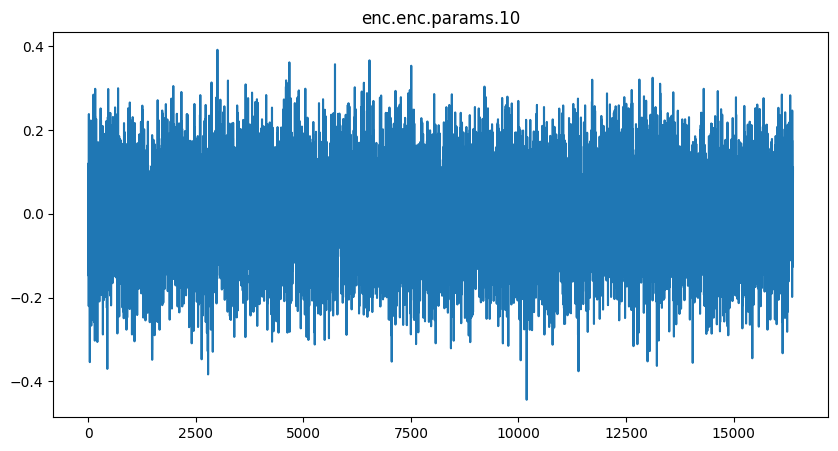

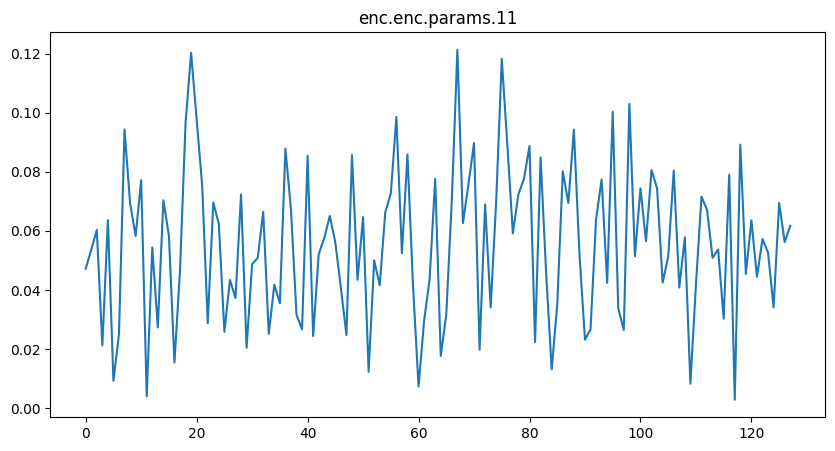

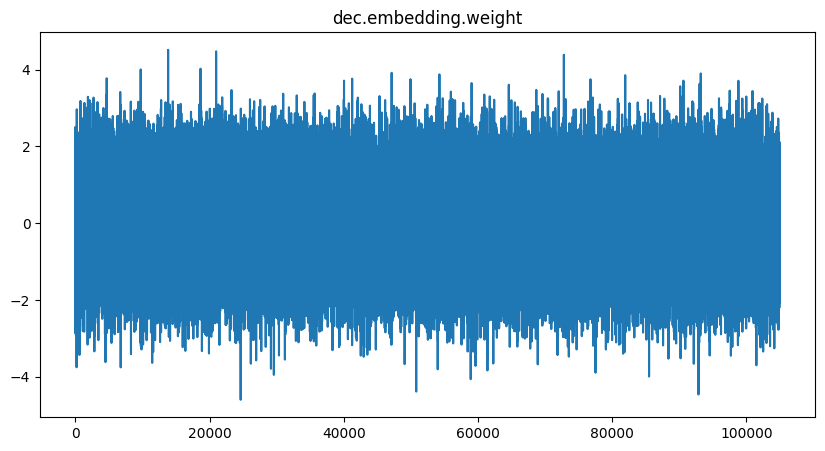

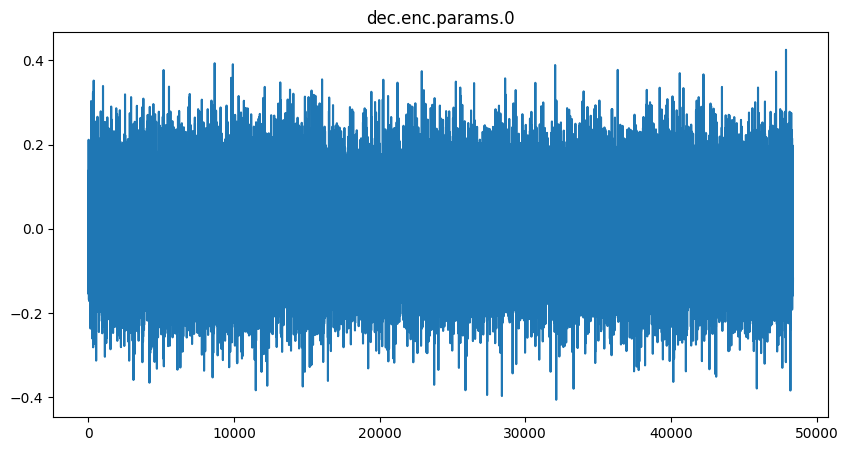

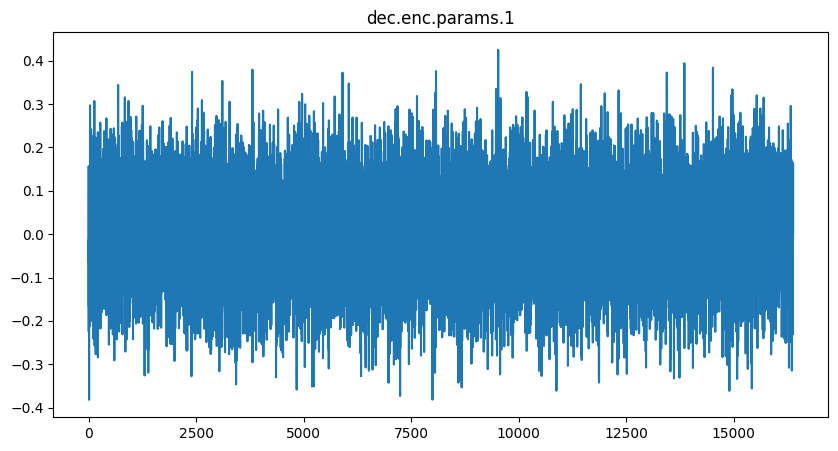

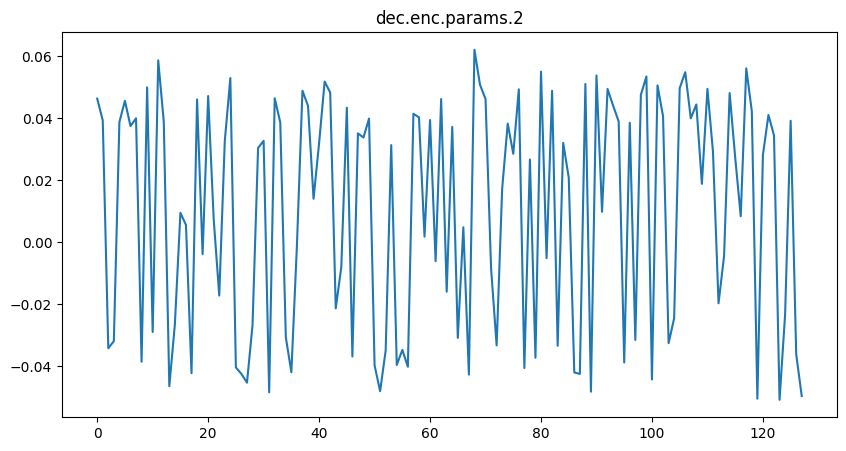

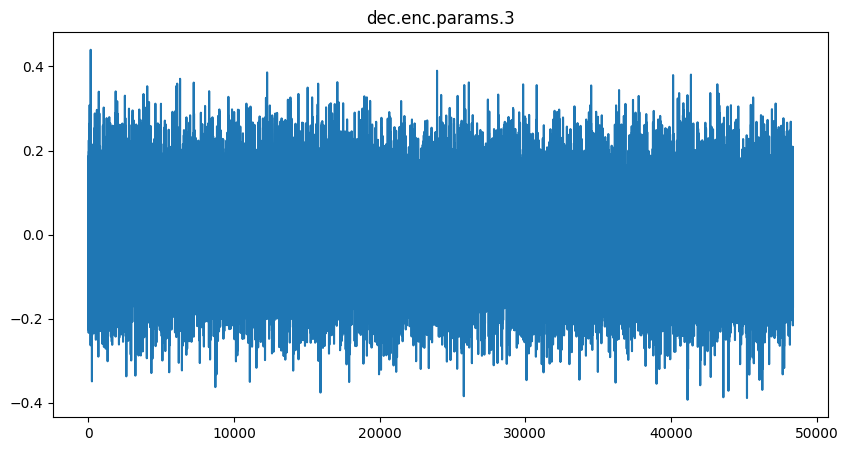

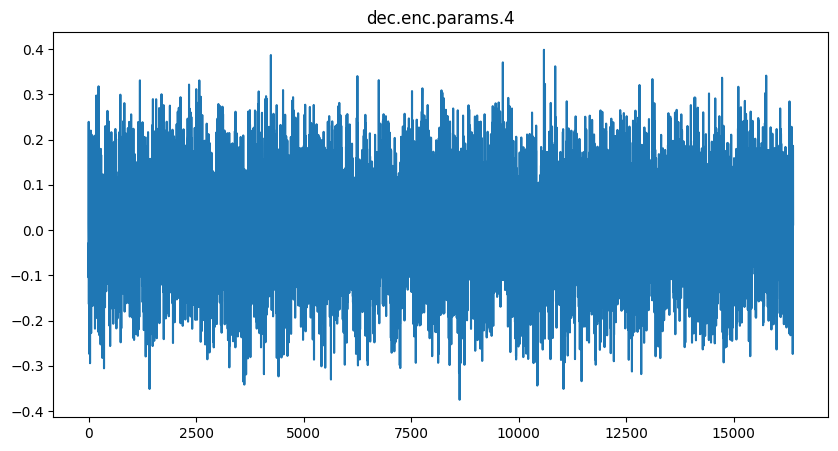

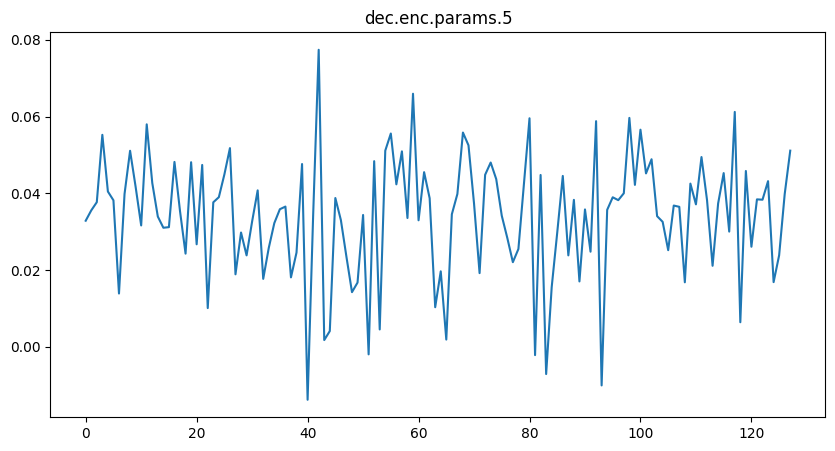

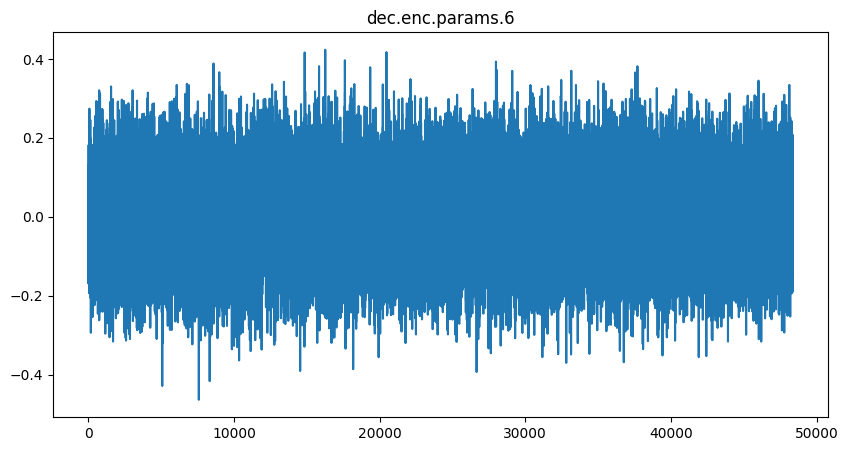

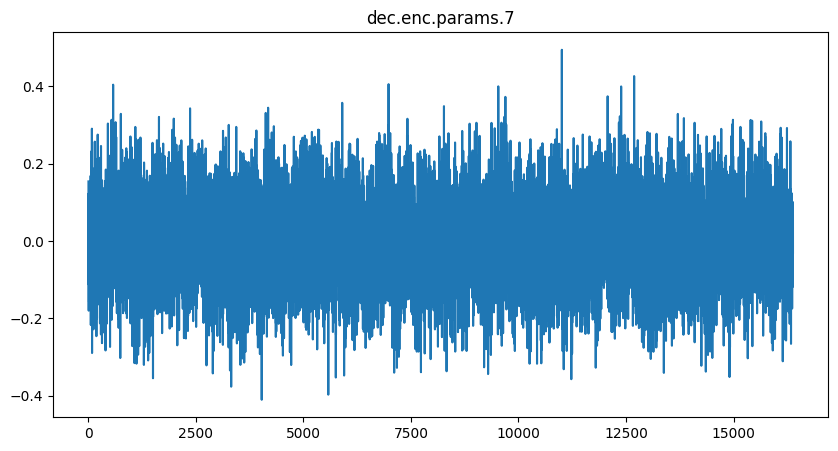

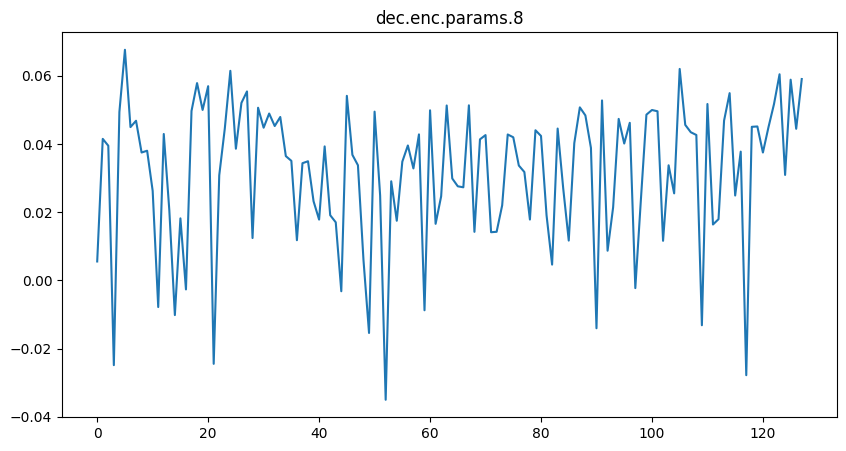

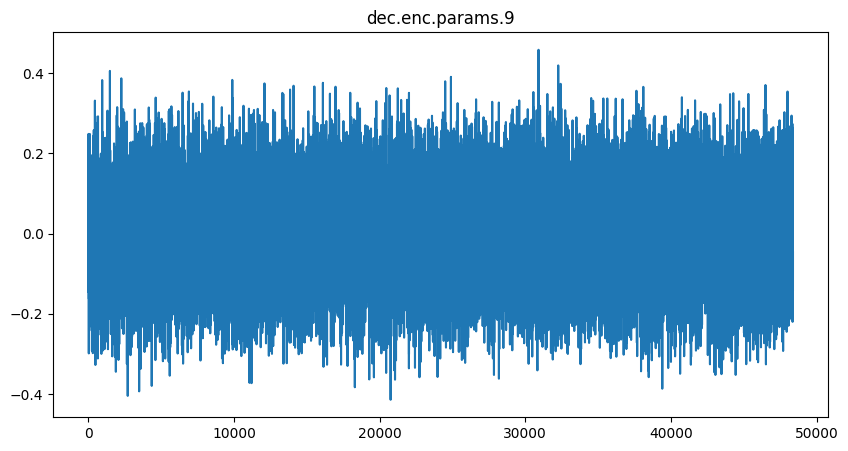

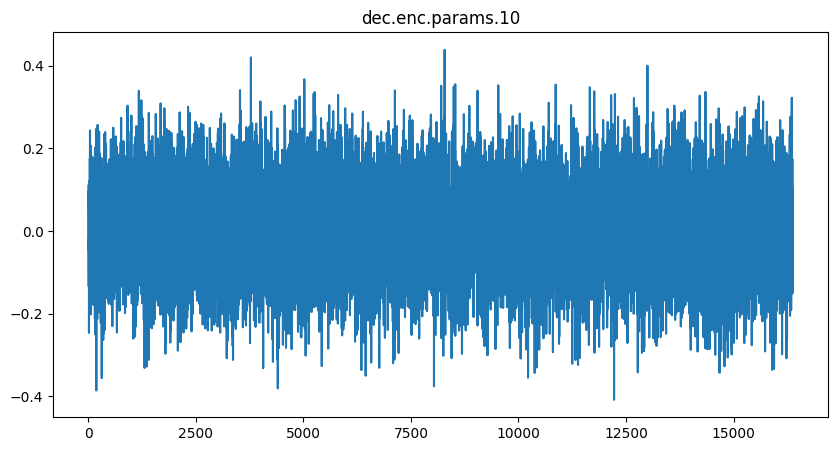

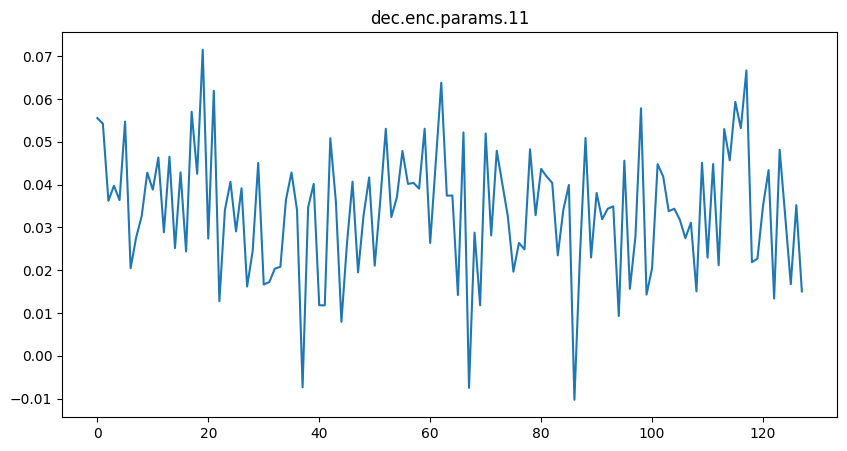

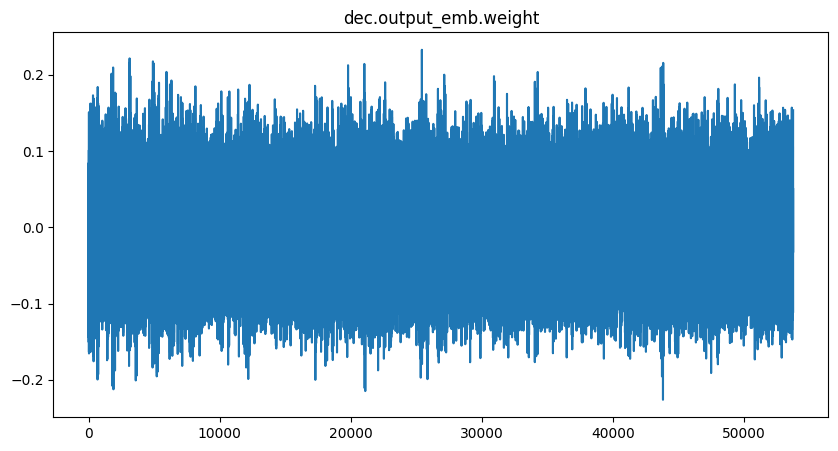

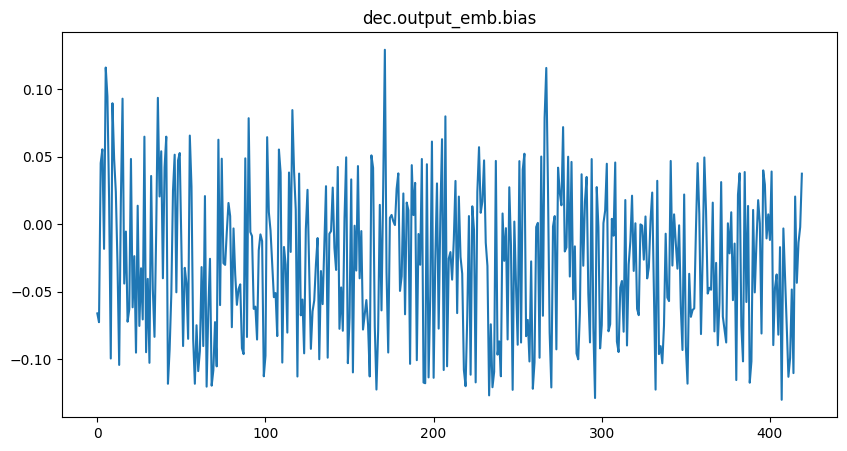

iter 149 / 7450	Loss:	11.643087
pred:	 tensor([3, 5, 2, 5, 5, 2, 2, 2, 2, 2])

tgt:	 tensor([3, 5, 2, 0, 0, 0, 0, 0, 0])

iter 298 / 7450	Loss:	9.040825
pred:	 tensor([3, 5, 2, 5, 5, 5, 5, 5, 2, 2])

tgt:	 tensor([3, 5, 2, 0, 0, 0, 0, 0, 0])

iter 447 / 7450	Loss:	7.296668
pred:	 tensor([3, 5, 2, 5, 5, 5, 5, 5, 2, 2])

tgt:	 tensor([3, 5, 2, 0, 0, 0, 0, 0, 0])

iter 596 / 7450	Loss:	6.088403
pred:	 tensor([3, 5, 2, 3, 5, 5, 5, 5, 3, 3])

tgt:	 tensor([3, 5, 2, 0, 0, 0, 0, 0, 0])

iter 745 / 7450	Loss:	5.200704
pred:	 tensor([3, 5, 2, 3, 5, 3, 3, 3, 3, 3])

tgt:	 tensor([3, 5, 2, 0, 0, 0, 0, 0, 0])

iter 894 / 7450	Loss:	4.459824
pred:	 tensor([3, 5, 2, 3, 5, 3, 3, 3, 3, 3])

tgt:	 tensor([3, 5, 2, 0, 0, 0, 0, 0, 0])

iter 1043 / 7450	Loss:	3.868437
pred:	 tensor([3, 5, 2, 3, 5, 3, 3, 3, 3, 3])

tgt:	 tensor([3, 5, 2, 0, 0, 0, 0, 0, 0])

iter 1192 / 7450	Loss:	3.361799
pred:	 tensor([3, 5, 2, 3, 5, 3, 3, 3, 3, 3])

tgt:	 tensor([3, 5, 2, 0, 0, 0, 0, 0, 0])

iter 1341 / 7450	Loss:	2.9422

In [ ]:
def train_lstm(net, train_iter, valid_iter, lr, epochs, device):
  # training
  net = net.to(device)

  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  train_loss_list = []
  valid_loss_list = []
  print_interval = len(train_iter)
  total_iter = epochs * len(train_iter)
  for e in range(epochs):
    net.train()
    epoch_train_loss = 0
    for i, train_data in enumerate(train_iter):
      train_data = [ds.to(device) for ds in train_data]
      loss, pred= net(*train_data)

      epoch_train_loss += loss.mean().item()
      optimizer.zero_grad()
      loss.mean().backward()
      optimizer.step()

      step = i + e * len(train_iter)
      if step % print_interval == 0:
        print('iter {} / {}\tLoss:\t{:.6f}'.format(step, total_iter, loss.mean().detach()))
        print('pred:\t {}\n'.format(pred[0].detach().cpu()))
        print('tgt:\t {}\n'.format(train_data[2][0][1:].cpu()))


    train_loss_list.append(epoch_train_loss / len(train_iter))

    if(e%3725==0):
        plot_weights(net)

    # Validation
    net.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
      for valid_data in valid_iter:
        valid_data = [ds.to(device) for ds in valid_data]
        loss, _ = net(*valid_data)
        epoch_valid_loss += loss.mean().item()

    valid_loss_list.append(epoch_valid_loss / len(valid_iter))

  return train_loss_list, valid_loss_list

seed(1)
# seed = 1
# random.seed(seed)
# torch.manual_seed(seed)
batch_size = 32
lr = 1e-3
epochs = 50

embedding_dim = 250
hidden_size = 128

vocab_eng, vocab_fra, full_iter = load_data_nmt(batch_size)

# split dataset
total_size = len(full_iter.dataset)
train_size = int(total_size * 0.95)
valid_size = total_size - train_size
train_dataset, valid_dataset = random_split(full_iter.dataset, [train_size, valid_size])

# Create new DataLoaders
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
valid_iter = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

lstm_net = NMTLSTM(vocab_eng.num_word, vocab_fra.num_word, embedding_dim, hidden_size, device)
train_loss_list, valid_loss_list = train_lstm(lstm_net, train_iter, valid_iter, lr, epochs, device)


The above plot shows the training loss after selected epochs, predicted tensors, target tensors and also values of weights in the epoch.(Scroll up and down). Note that, Tensors represent words.

### LSTM Loss Curve

Plot the loss curve over time.

In [ ]:
import plotly.graph_objects as go

def plot_loss(train_loss_list, valid_loss_list):
    epochs = list(range(1, len(train_loss_list) + 1))

    fig = go.Figure()

    # Add traces
    fig.add_trace(go.Scatter(x=epochs, y=train_loss_list,
                        mode='lines+markers',
                        name='Training Loss'))
    fig.add_trace(go.Scatter(x=epochs, y=valid_loss_list,
                        mode='lines+markers',
                        name='Validation Loss'))

    # Set title and labels
    fig.update_layout(
        title="Training and Validation Loss over Epochs",
        xaxis_title="Epochs",
        yaxis_title="Loss",
        legend_title="Loss Types",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple"
        )
    )

    # Show the plot
    fig.show()

# Call the function to create the plot
plot_loss(train_loss_list, valid_loss_list)


##4.7 Testing the model

In [ ]:
def comp_acc(pred, gt, valid_len):
  N, T_gt = gt.shape[:2]
  _, T_pr = pred.shape[:2]
  assert T_gt == T_pr, 'Prediction and target should have the same length.'
  len_mask = torch.arange(T_gt).expand(N, T_gt)
  len_mask = len_mask < (valid_len - 1)[:, None]

  pred_crr = (pred == gt).float() * len_mask.float() # filter out the 'bos' token
  pred_acc = pred_crr.sum(dim=-1) / (valid_len - 1).float() # minus the 'bos' token
  return pred_acc

def evaluate_lstm(net, valid_iter, device):
  acc_list = []
  for i, valid_data in enumerate(valid_iter):
    valid_data = [ds.to(device) for ds in valid_data]

    pred = net.predict(*valid_data)

    pred_acc = comp_acc(pred.detach().cpu(), valid_data[2].detach().cpu()[:, 1:], valid_data[3].cpu())
    acc_list.append(pred_acc)
    if i < 5:  # print 5 samples from 5 batches
      pred = pred[0].detach().cpu()
      pred_seq = []
      for t in range(MAX_LEN+1):
        pred_wd = vocab_fra.index2word[pred[t].item()]
        if pred_wd == 'eos':
          break
        pred_seq.append(pred_wd)

      print('pred:\t {}\n'.format(pred_seq))
      print('tgt:\t {}\n'.format([vocab_fra.index2word[t.item()] for t in valid_data[2][0][1:].cpu()]))

  print('Prediction Acc.: {:.4f}'.format(torch.cat(acc_list).mean()))
  acc_final = torch.cat(acc_list).mean()
  return acc_final

seed(1)
# random.seed(seed)
# torch.manual_seed(seed)
batch_size = 32

vocab_eng, vocab_fra, full_iter = load_data_nmt(batch_size)


acc_final = evaluate_lstm(lstm_net, valid_iter, device)


(tensor([4, 5, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(2), tensor([1, 4, 5, 2, 0, 0, 0, 0, 0, 0]), tensor(4))
pred:	 ['je', 'suis', 'unk', '.']

tgt:	 ['je', 'suis', 'unk', '.', 'eos', 'pad', 'pad', 'pad', 'pad']

pred:	 ["j'étais", 'unk', '.']

tgt:	 ["j'étais", 'unk', '.', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad']

pred:	 ['je', 'unk', '.']

tgt:	 ['je', 'unk', '.', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad']

pred:	 ['on', "m'a", 'unk', '.']

tgt:	 ['je', 'me', 'suis', 'fait', 'prendre', '.', 'eos', 'pad', 'pad']

pred:	 ['je', 'suis', 'unk', '.']

tgt:	 ['je', 'suis', 'unk', '!', 'eos', 'pad', 'pad', 'pad', 'pad']

Prediction Acc.: 0.5813


The above result shows the model predictions and what our targets were. We have got prediction accuracy of 58.13% in validation data which is better than the prediction accuracy we got from vanilla RNN.

This is the end of the implementation. In this notebook, I implemented vanilla RNN and also RNN with LSTM and Attention. I have shown that incorporating LSTM and attention mechanism helps improve the performance of the model.

##5. Sources



**Sources**

1."Sequence to Sequence Learning with Neural Networks" by Ilya Sutskever, Oriol Vinyals, and Quoc V. Le. https://arxiv.org/abs/1409.3215

2."Neural Machine Translation by Jointly Learning to Align and Translate" by Dzmitry Bahdanau, Kyunghyun Cho, and Yoshua Bengio.https://arxiv.org/abs/1409.0473

3."Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation" by Kyunghyun Cho, Bart van Merrienboer, Caglar Gulcehre, Dzmitry Bahdanau, Fethi Bougares, Holger Schwenk, and Yoshua Bengio. https://arxiv.org/abs/1406.1078

4."Long Short-Term Memory" by Sepp Hochreiter and Jürgen Schmidhuber.
 https://www.mitpressjournals.org/doi/pdf/10.1162/neco.1997.9.8.1735

5."Deep Learning" by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.
https://www.deeplearningbook.org/

6."Natural Language Processing with PyTorch" by Delip Rao and Brian McMahan.

7."Understanding LSTM Networks" by Christopher Olah.
 https://colah.github.io/posts/2015-08-Understanding-LSTMs/

8."LSTM by Example using Tensorflow" by Aymeric Damien.
https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/recurrent_network.ipynb

9.Building a Recurrent Neural Network (RNN) tutorial" by Denny Britz.
http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/



> **Thank You!!**



Student Information:

> Name:Tadiwos Meaza

> Student ID:20210775




